In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import requests
import json
from bs4 import BeautifulSoup

import pandas as pd
import numpy as np
from pandas import DataFrame, Series
import matplotlib.pyplot as plt

import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import learning_curve

from sklearn.utils.class_weight import compute_sample_weight

In [2]:
all_seasons = []

for season in range(2023, 2024):
    summary_url = f"https://api.nhle.com/stats/rest/en/skater/summary?limit=-1&cayenneExp=seasonId={season}{season+1}%20and%20gameTypeId=2"

    try:
        summary_resp = requests.get(summary_url)
        summary_resp.raise_for_status() 
        summary_json =  summary_resp.json()

        if summary_json['data']:
            df_summary = DataFrame(summary_json['data'])
            all_seasons.append(df_summary)
            df_summary['season'] = f"{season}-{season + 1}"
            print(f"Successfully fetched data for season {season}-{season+1}")
        else:
            print(f"No data returned for season {season}-{season + 1}")
        
    except requests.exceptions.RequestException as e:
        print(f"Error fetching data for season {season}-{season + 1}: {e}")

if all_seasons:
    nhl_api_df = pd.concat(all_seasons, ignore_index=True)
    nhl_api_df = nhl_api_df.groupby('playerId').agg({
            'playerId': 'first',
            'skaterFullName': 'first',
            'positionCode': 'first',
            'gamesPlayed': 'sum',
            'assists': 'sum',
            'otGoals': 'sum',
            'gameWinningGoals': 'sum',
        }).reset_index(drop = True)
    
print(nhl_api_df)

Successfully fetched data for season 2023-2024
     playerId     skaterFullName positionCode  gamesPlayed  assists  otGoals  \
0     8470600         Ryan Suter            D           82       15        0   
1     8470604        Jeff Carter            C           72        4        0   
2     8470610        Zach Parise            L           30        5        0   
3     8470613        Brent Burns            D           82       33        0   
4     8470621        Corey Perry            R           54       10        0   
..        ...                ...          ...          ...      ...      ...   
919   8484314       Jiri Smejkal            L           20        1        0   
920   8484321  Nikolas Matinpalo            D            4        0        0   
921   8484325    Waltteri Merela            C           19        0        0   
922   8484326        Patrik Koch            D            1        0        0   
923   8484911        Collin Graf            R            7        2      

In [3]:
nhl_api_df = nhl_api_df.loc[(nhl_api_df['positionCode'] != 'D') & (nhl_api_df['gamesPlayed'] >= 60)]
nhl_api_df = nhl_api_df.reset_index(drop = True)
nhl_api_df = nhl_api_df.fillna(0)

nhl_api_df.rename(columns = {'gameWinningGoals': 'game_winning_goals'}, inplace = True)
nhl_api_df.rename(columns = {'otGoals': 'ot_goals'}, inplace = True)
nhl_api_df.rename(columns = {'skaterFullName': 'Player'}, inplace = True)
nhl_api_df['regulation_game_winning'] = nhl_api_df['game_winning_goals'] - nhl_api_df['ot_goals']

In [4]:
goals_up_one_url = "https://www.naturalstattrick.com/playerteams.php?fromseason=20232024&thruseason=20232024&stype=2&sit=all&score=u1&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"
goals_down_one_url = "https://www.naturalstattrick.com/playerteams.php?fromseason=20232024&thruseason=20232024&stype=2&sit=all&score=d1&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"
tied_url = "https://www.naturalstattrick.com/playerteams.php?fromseason=20232024&thruseason=20232024&stype=2&sit=all&score=tied&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"
total_url = "https://www.naturalstattrick.com/playerteams.php?fromseason=20232024&thruseason=20232024&stype=2&sit=all&score=all&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"

In [5]:
urls = {
    "goals_up_one": ("https://www.naturalstattrick.com/playerteams.php?fromseason=20232024&thruseason=20232024&stype=2&sit=all&score=u1&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL", 'goals_up_by_one'),
    "goals_down_one": ("https://www.naturalstattrick.com/playerteams.php?fromseason=20232024&thruseason=20232024&stype=2&sit=all&score=d1&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL", 'goals_down_by_one'),
    "tied": ("https://www.naturalstattrick.com/playerteams.php?fromseason=20232024&thruseason=20232024&stype=2&sit=all&score=tied&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL", 'goals_when_tied'),
    "total": ("https://www.naturalstattrick.com/playerteams.php?fromseason=20232024&thruseason=20232024&stype=2&sit=all&score=all&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL", 'total_goals'),
}

dataframes = {}

for name, (url, new_column_name) in urls.items():
    df = pd.read_html(url, header=0, index_col=0, na_values=["-"])[0]
    df.rename(columns={'Goals': new_column_name}, inplace=True)
    dataframes[name] = df

goals_up_one_df = dataframes["goals_up_one"]
goals_down_one_df = dataframes["goals_down_one"]
goals_tied_df = dataframes["tied"]
total_df = dataframes["total"]

In [6]:
goals_up_one_df = goals_up_one_df[['Player', 'GP', 'goals_up_by_one']]
goals_down_one_df = goals_down_one_df[['Player', 'goals_down_by_one']]
goals_tied_df = goals_tied_df[['Player', 'goals_when_tied']]
total_df = total_df[['Player', 'total_goals', 'Shots', 'ixG', 'iFF', 'iSCF', 'iHDCF', 'Rush Attempts', 'iCF', 'Rebounds Created']]

dfs_natural_stat = [goals_up_one_df, goals_down_one_df, goals_tied_df, total_df]

import functools as ft
merged_natural_stat = ft.reduce(lambda left, right: pd.merge(left, right, on='Player'), dfs_natural_stat)
merged_natural_stat = merged_natural_stat.loc[merged_natural_stat['GP'] >= 60]
merged_natural_stat.rename(columns={'Shots': 'shots'}, inplace=True)
merged_natural_stat.rename(columns={'Rush Attempts': 'rush_attempts'}, inplace=True)

In [7]:
natural_stat_names = ["Pat Maroon", "Alex Kerfoot", "Nicholas Paul", "Zach Sanford", "Alex Wennberg", "Mitchell Marner", "Zach Aston-Reese",  "Max Comtois", "Alexei Toropchenko", "Cameron Atkinson"]
nhl_names = ["Patrick Maroon", "Alexander Kerfoot", "Nick Paul", "Zachary Sanford", "Alexander Wennberg", "Mitch Marner", "Zachary Aston-Reese",  "Maxime Comtois", "Alexey Toropchenko", "Cam Atkinson"]
merged_natural_stat = merged_natural_stat.replace(natural_stat_names, nhl_names)

In [8]:
merged_natural_stat

,Player,GP,goals_up_by_one,goals_down_by_one,goals_when_tied,total_goals,shots,ixG,iFF,iSCF,iHDCF,rush_attempts,iCF,Rebounds Created
0,Jeff Carter,72,4,3,3,11,90,11.45,134,95,53,9,175,18
3,Joe Pavelski,82,7,4,10,27,194,28.18,261,232,130,7,329,34
4,Alex Ovechkin,79,7,2,7,31,272,29.89,395,245,83,17,605,64
5,Evgeni Malkin,82,3,6,6,27,199,23.56,280,218,82,6,401,47
7,Sidney Crosby,82,8,6,15,42,278,38.58,398,287,131,17,490,52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
549,Logan Cooley,82,2,2,8,20,151,16.52,217,147,57,8,284,21
556,Juraj Slafkovsky,82,2,4,5,20,152,21.56,226,198,98,5,314,27
564,Andrei Kuzmenko,72,3,5,6,22,121,19.29,197,182,97,4,265,40
566,Connor Bedard,68,2,6,9,22,206,23.82,299,226,69,17,401,34


In [9]:
nhl_api_df

,playerId,Player,positionCode,gamesPlayed,assists,ot_goals,game_winning_goals,regulation_game_winning
0,8470604,Jeff Carter,C,72,4,0,4,4
1,8470794,Joe Pavelski,C,82,40,1,4,3
2,8471214,Alex Ovechkin,L,79,34,1,5,4
3,8471215,Evgeni Malkin,C,82,40,0,2,2
4,8471675,Sidney Crosby,C,82,52,0,3,3
...,...,...,...,...,...,...,...,...
311,8483431,Logan Cooley,C,82,24,1,2,1
312,8483515,Juraj Slafkovsky,L,82,30,0,2,2
313,8483808,Andrei Kuzmenko,L,72,24,1,4,3
314,8484144,Connor Bedard,C,68,39,1,2,1


In [10]:
merged_clutch_goals = nhl_api_df.merge(merged_natural_stat, on = 'Player', how = 'left')

In [11]:
merged_clutch_goals

,playerId,Player,positionCode,gamesPlayed,assists,ot_goals,game_winning_goals,regulation_game_winning,GP,goals_up_by_one,...,goals_when_tied,total_goals,shots,ixG,iFF,iSCF,iHDCF,rush_attempts,iCF,Rebounds Created
0,8470604,Jeff Carter,C,72,4,0,4,4,72,4,...,3,11,90,11.45,134,95,53,9,175,18
1,8470794,Joe Pavelski,C,82,40,1,4,3,82,7,...,10,27,194,28.18,261,232,130,7,329,34
2,8471214,Alex Ovechkin,L,79,34,1,5,4,79,7,...,7,31,272,29.89,395,245,83,17,605,64
3,8471215,Evgeni Malkin,C,82,40,0,2,2,82,3,...,6,27,199,23.56,280,218,82,6,401,47
4,8471675,Sidney Crosby,C,82,52,0,3,3,82,8,...,15,42,278,38.58,398,287,131,17,490,52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311,8483431,Logan Cooley,C,82,24,1,2,1,82,2,...,8,20,151,16.52,217,147,57,8,284,21
312,8483515,Juraj Slafkovsky,L,82,30,0,2,2,82,2,...,5,20,152,21.56,226,198,98,5,314,27
313,8483808,Andrei Kuzmenko,L,72,24,1,4,3,72,3,...,6,22,121,19.29,197,182,97,4,265,40
314,8484144,Connor Bedard,C,68,39,1,2,1,68,2,...,9,22,206,23.82,299,226,69,17,401,34


In [12]:
null_rows = merged_clutch_goals[merged_clutch_goals.isnull().any(axis=1)]
print("Rows with null values:")
print(null_rows)

Rows with null values:
Empty DataFrame
Columns: [playerId, Player, positionCode, gamesPlayed, assists, ot_goals, game_winning_goals, regulation_game_winning, GP, goals_up_by_one, goals_down_by_one, goals_when_tied, total_goals, shots, ixG, iFF, iSCF, iHDCF, rush_attempts, iCF, Rebounds Created]
Index: []

[0 rows x 21 columns]


In [17]:
merged_clutch_goals.drop(columns = 'GP', axis = 1, inplace = True)

In [18]:
columns = ['ot_goals', 'regulation_game_winning', 'assists', 'goals_up_by_one', 'goals_down_by_one', 'goals_when_tied', 'shots', 'ixG', 'iFF', 'iSCF', 'iHDCF', 'rush_attempts','iCF', 'Rebounds Created']
for column in columns:
    per_game_string = f"{column}_per_game"
    merged_clutch_goals[per_game_string] = merged_clutch_goals[column] / merged_clutch_goals['gamesPlayed']


In [19]:
merged_clutch_goals['clutch_score'] = 0.3 * merged_clutch_goals['goals_when_tied_per_game'] + 0.3 * merged_clutch_goals['goals_down_by_one_per_game'] + 0.2 * merged_clutch_goals['goals_up_by_one_per_game'] + 0.1 * merged_clutch_goals['regulation_game_winning_per_game'] + 0.1 * merged_clutch_goals['ot_goals_per_game']

In [20]:
merged_clutch_goals['clutch_score'] *= 100
merged_clutch_goals['clutch_score_rank']  = merged_clutch_goals['clutch_score'].rank(ascending = False)
merged_clutch_goals['clutch_score'] = merged_clutch_goals['clutch_score'].apply(lambda x: round(x, 2))
merged_clutch_goals.sort_values('clutch_score_rank', inplace = True)
merged_clutch_goals[['Player','clutch_score', 'clutch_score_rank']].head(80)

,Player,clutch_score,clutch_score_rank
205,Auston Matthews,18.15,1.0
138,Sam Reinhart,15.49,2.0
150,David Pastrnak,13.78,3.0
166,Kyle Connor,12.92,4.0
197,Kirill Kaprizov,12.80,5.0
...,...,...,...
289,Jake Neighbours,6.62,76.0
113,Anthony Duclair,6.58,77.0
79,Mika Zibanejad,6.54,78.0
73,Brandon Saad,6.46,79.0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


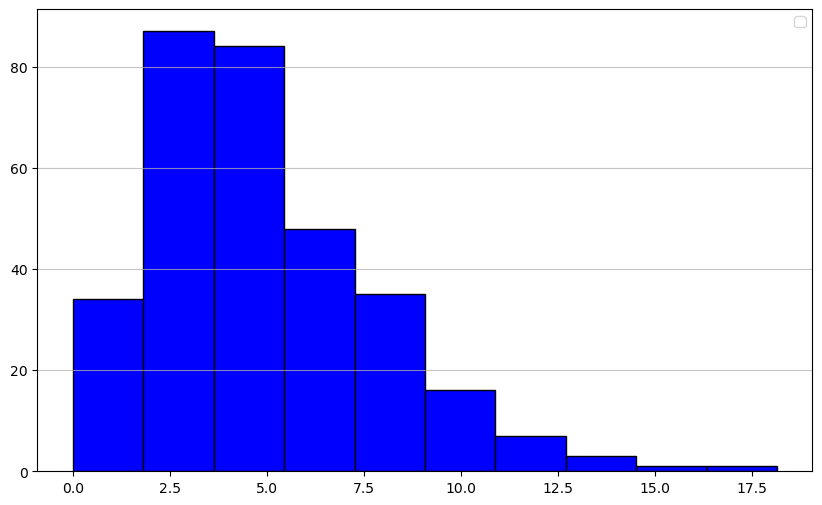

In [21]:
plt.figure(figsize=(10, 6))
plt.hist(merged_clutch_goals['clutch_score'], color='blue', edgecolor='black')
plt.grid(axis='y', alpha=0.75)
plt.legend()
plt.show()

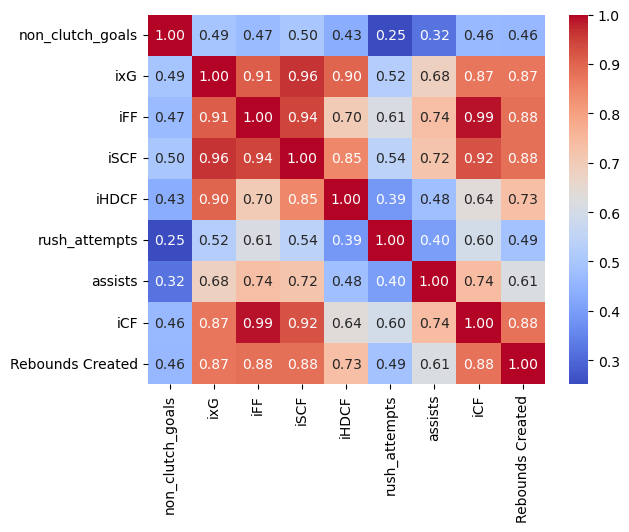

In [35]:
import seaborn as sns

merged_clutch_goals['non_clutch_goals'] = merged_clutch_goals['total_goals'] - (merged_clutch_goals['game_winning_goals'] + merged_clutch_goals['goals_down_by_one'] + merged_clutch_goals['goals_up_by_one'] + merged_clutch_goals['goals_when_tied'])


x_var = ['non_clutch_goals','ixG', 'iFF', 'iSCF', 'iHDCF', 'rush_attempts', 'assists', 'iCF', 'Rebounds Created']
X_adjusted = merged_clutch_goals[x_var]

corr_matrix = X_adjusted.corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.show()

In [37]:
threshold_elite = merged_clutch_goals['clutch_score'].quantile(0.85)
threshold_high = merged_clutch_goals['clutch_score'].quantile(0.7)
threshold_average = merged_clutch_goals['clutch_score'].quantile(0.5)


def label_clutchness(row):
    clutch_score = row['clutch_score']
    if clutch_score >= threshold_elite:
        return 1
    else:
        return 0

merged_clutch_goals['clutch_label'] = merged_clutch_goals.apply(label_clutchness, axis=1)

In [39]:
merged_clutch_goals['clutch_label'].value_counts()

clutch_label
0    268
1     48
Name: count, dtype: int64

In [ ]:
x_var = ['shots_per_game', 'ixG_per_game', 'iFF_per_game', 'iSCF_per_game', 'iHDCF_per_game', 'rush_attempts_per_game', 'non_clutch_goals_per_]
y_var = 'clutch_label'

X = merged_clutch_goals[x_var]
y = merged_clutch_goals[y_var]

train_x, test_x, train_y, test_y = train_test_split(X, y, test_size = 0.2, stratify = y)
xgb_model = xgb.XGBClassifier(n_estimators=100, eval_metric='logloss')
xgb_model.fit(train_x, train_y)

In [ ]:
skf = StratifiedKFold(n_splits=10)

scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

scores = cross_validate(xgb_model, X, y, cv = skf, scoring = scoring)

df_scores = pd.DataFrame.from_dict(scores)

df_scores.mean()

In [ ]:
cv = StratifiedKFold(n_splits=10)

train_sizes = np.linspace(0.1, 1.0, 10)
    
train_sizes, train_scores, valid_scores = learning_curve(
    xgb_model, X, y, 
    cv=cv,
    n_jobs=-1,
    train_sizes=train_sizes,
    scoring='neg_log_loss',
)

train_mean = -np.mean(train_scores, axis=1)
train_std = -np.std(train_scores, axis=1)
valid_mean = -np.mean(valid_scores, axis=1)
valid_std = -np.std(valid_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training score', color='blue')
plt.plot(train_sizes, valid_mean, label='Cross-validation score', color='red')

plt.title(f'Learning Curves')
plt.xlabel('Training Examples')
plt.ylabel('Log Loss')
plt.grid(True)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

In [ ]:
plot_importance(xgb_model)
plt.show()

In [ ]:
merged_clutch_goals.columns

In [ ]:
from skopt import BayesSearchCV
import xgboost as xgb
import time
import math
from skopt.space import Integer, Real
from scipy.stats import randint, uniform
from skopt.space import Real, Integer, Categorical

param_grid = {
    'max_depth': Integer(2,5),  # Reduced from 5 to limit complexity
    'min_child_weight': Integer(2,3),  # Increased to prevent overfitting
    'n_estimators': Integer(200, 300),  # Narrowed based on your curves
    'learning_rate': Real(0.03, 0.04),  # Slightly lower than current ~0.14
    'reg_alpha': Real(0.75, 1.9),  # Reduced from current ~1.87
    'reg_lambda': Real(0.75, 1.9),  # Reduced from current ~2.92
    'subsample': Real(0.7, 1),  # Slightly higher than current ~0.74
    'colsample_bytree': Real(0.7, 1)  # Higher than current ~0.64
}


def learning_rate_schedule(iteration):
    return 0.1 * (0.99 ** iteration)

# Modified fit parameters
fit_params = {
    'early_stopping_rounds': 35,  # More aggressive stopping
}


In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pyplot
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold
from skopt import BayesSearchCV
import xgboost as xgb

cv = StratifiedKFold(n_splits=10)

accuracy_list = []
precision_list = []
recall_list = []
f1_list = []
best_hyperparams_list = []

def plot_learning_curves(estimator, X, y, cv, iteration, title):

    train_sizes = np.linspace(0.1, 1.0, 10)
    
    # Calculate learning curves
    train_sizes, train_scores, valid_scores = learning_curve(
        estimator, X, y, 
        cv=cv,
        n_jobs=-1,
        train_sizes=train_sizes,
        scoring='neg_log_loss'
    )

    # Calculate mean and std
    train_mean = -np.mean(train_scores, axis=1)
    train_std = -np.std(train_scores, axis=1)
    valid_mean = -np.mean(valid_scores, axis=1)
    valid_std = -np.std(valid_scores, axis=1)
    
    # Plot learning curves
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, label='Training score', color='blue')
    
    plt.plot(train_sizes, valid_mean, label='Cross-validation score', color='red')
    
    plt.title(f'Learning Curves - Iteration {iteration}\n{title}')
    plt.xlabel('Training Examples')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()


for _ in range(1):
    rs = np.random.randint(1, 1000)

    train_x, test_x, train_y, test_y = train_test_split(
    X_adjusted, 
    y, 
    test_size=0.2, 
    stratify=y,
    random_state = rs
    )

    class_weights = compute_sample_weight(class_weight='balanced', y=train_y)
    
    xgb_model_adjusted = xgb.XGBClassifier(n_estimators = 100, eval_metric = 'logloss')
    xgb_model_adjusted.fit(train_x, train_y, sample_weight = class_weights)

    random_search = BayesSearchCV(xgb_model_adjusted, param_grid, cv=cv, n_iter=20, scoring= ['recall'], refit='recall', n_jobs = -1, fit_params = fit_params)

    new = random_search.fit(train_x,train_y)

    xgb_best_model = new.best_estimator_
    
    title = f'Best Parameters: {random_search.best_params_}'
    #plot_learning_curves(xgb_best_model, train_x, train_y, cv, _+1, title)

  
    y_pred = xgb_best_model.predict(test_x)
    y_pred_prob = xgb_best_model.predict_proba(test_x)  # Probabilities for all classes

    # Metrics
    accuracy = accuracy_score(test_y, y_pred)
    precision = precision_score(test_y, y_pred, zero_division=0)
    recall = recall_score(test_y, y_pred)
    f1 = f1_score(test_y, y_pred)
    print(accuracy)
    print(precision)
    print(recall)
    print(f1)

    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

    best_hyperparams_list.append(random_search.best_params_)

print("Average Accuracy:", np.mean(accuracy_list))
print("Average Precision:", np.mean(precision_list))
print("Average Recall:", np.median(recall_list))
print("Average F1 Score:", np.mean(f1_list))

hyperparams_df = pd.DataFrame(best_hyperparams_list)
averaged_hyperparams = hyperparams_df.mean()
print("Averaged Hyperparameters:")
print(averaged_hyperparams)

ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

conf_matrix = confusion_matrix(test_y, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)

disp.plot()
plt.suptitle('Confusion Matrix for XGBoost')
plt.show()

In [ ]:
results = pd.DataFrame({'Actual': test_y, 'Predicted': y_pred})
misclassifications = results[results['Actual'] == 1]
print(misclassifications)

In [ ]:
y_pred_prob

In [ ]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    xgb_best_model, test_x, test_y
)
_ = display.ax_.set_title("2-class Precision-Recall curve")


In [ ]:
merged_clutch_goals.loc[82]

In [51]:
x_var = ['shots_per_game', 'ixG_per_game', 'iFF_per_game', 'iSCF_per_game', 'iHDCF_per_game', 'rush_attempts_per_game', 'assists_per_game', 'iCF_per_game', 'Rebounds Created_per_game']
X= merged_clutch_goals[x_var]
y_var = 'clutch_score'  
y = merged_clutch_goals[y_var]

correlation = X.corrwith(y) 
print(correlation)

shots_per_game               0.811868
ixG_per_game                 0.799347
iFF_per_game                 0.819012
iSCF_per_game                0.820075
iHDCF_per_game               0.608481
rush_attempts_per_game       0.446478
assists_per_game             0.662297
iCF_per_game                 0.806047
Rebounds Created_per_game    0.674669
dtype: float64


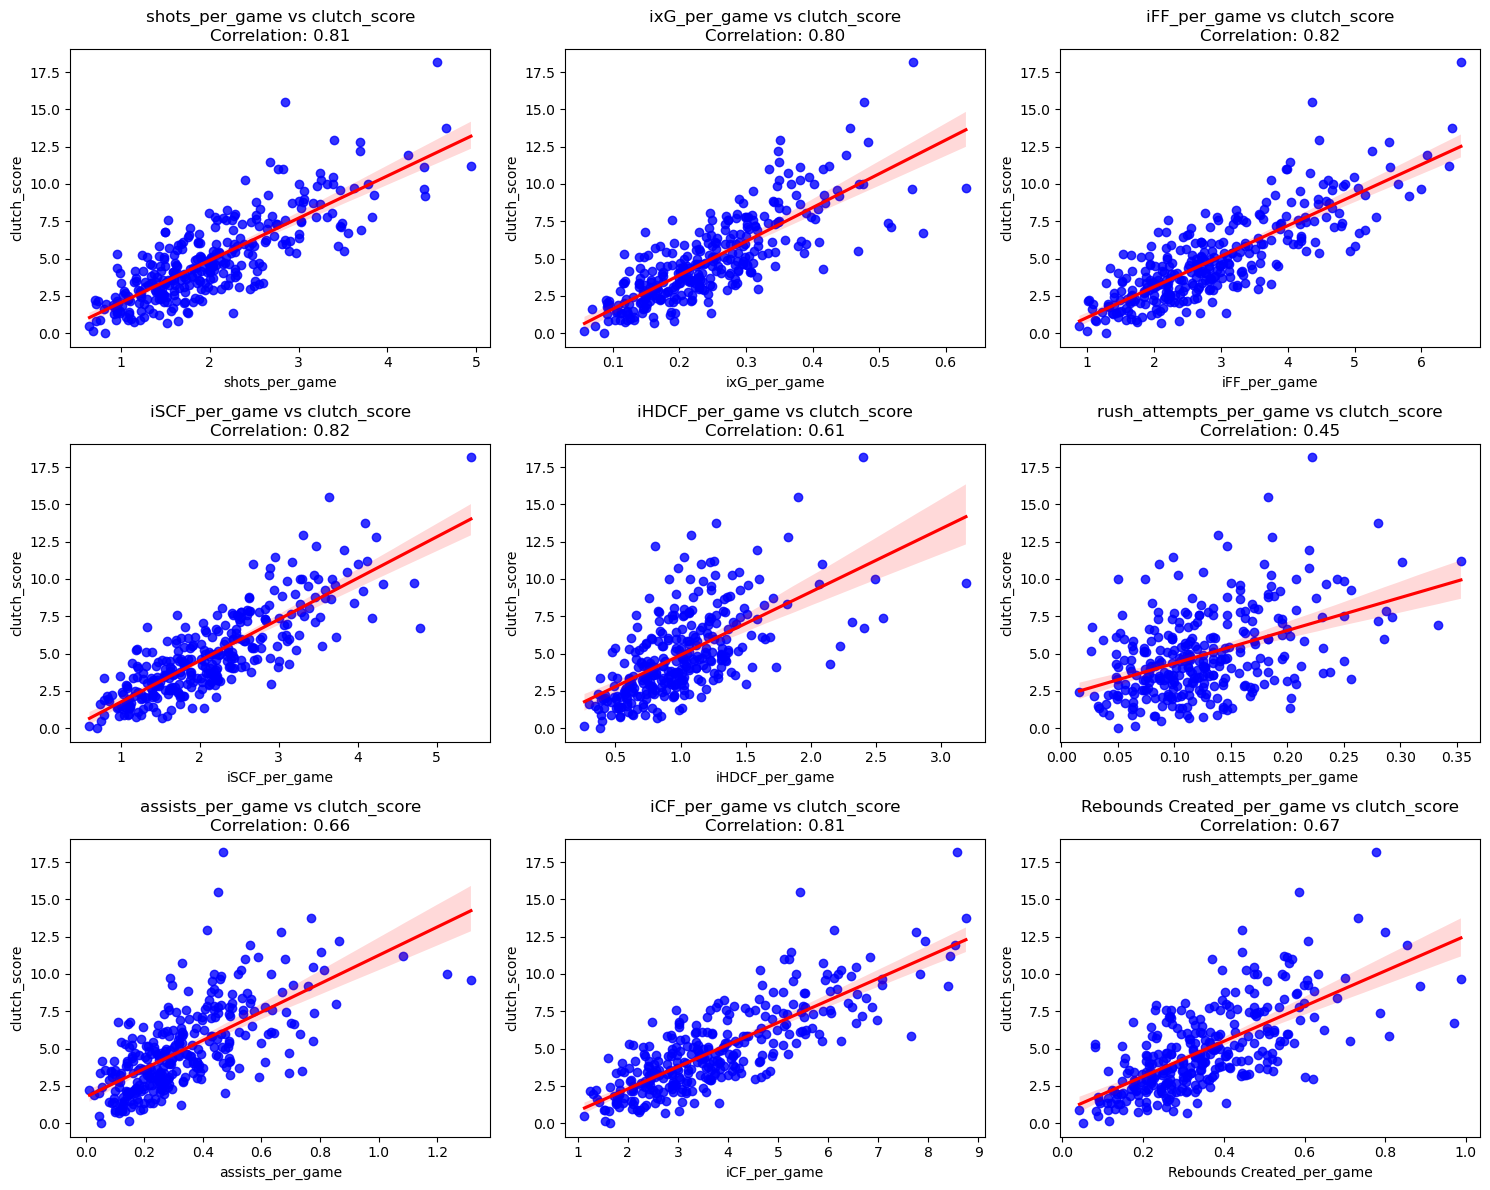

In [89]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming x_var, y, and correlation are already defined

plt.figure(figsize=(15, 12))  # Adjust the size of the plot

for i, var in enumerate(x_var):
    plt.subplot(3, 3, i+1)  # 3x3 grid of subplots (adjust rows and columns as needed)
    
    # Use sns.regplot for scatter plot with regression line
    sns.regplot(data=merged_clutch_goals, x=var, y=y, scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
    
    plt.title(f'{var} vs {y_var}\nCorrelation: {correlation[var]:.2f}', fontsize=12)
    plt.xlabel(var)
    plt.ylabel(y_var)

plt.tight_layout()  # Adjust spacing between subplots
plt.show()


In [139]:
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

x_var = ['shots_per_game', 'ixG_per_game', 'iFF_per_game', 'iSCF_per_game', 'iHDCF_per_game', 
         'rush_attempts_per_game', 'assists_per_game', 'iCF_per_game', 'Rebounds Created_per_game']
X_adjusted = merged_clutch_goals[x_var]
y_var = 'clutch_score' 
y = merged_clutch_goals[y_var]

train_x, test_x, train_y, test_y = train_test_split(
    X_adjusted, 
    y, 
    test_size=0.2, 
    random_state=42
)

regression_linear = LinearRegression().fit(train_x, train_y)

y_pred = regression_linear.predict(test_x)

mse = mean_squared_error(test_y, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_y, y_pred)
r2 = r2_score(test_y, y_pred)

print("MSE: ", mse)
print("RMSE: ", rmse)
print("R2: ", r2)
print("R2 Adjsuted: ", 1 - ( 1-regression_linear.score(train_x, train_y) ) * ( len(train_y) - 1 ) / ( len(train_y) - train_x.shape[1] - 1 ))

MSE:  2.3207198497977073
RMSE:  1.5233909051184817
R2:  0.7132393546738738
R2 Adjsuted:  0.726068722454452


In [141]:
results = pd.DataFrame({'Player': merged_clutch_goals.loc[test_y.index, 'Player'], 'Actual': test_y, 'Predicted': y_pred})

results['Error'] = abs(results['Actual'] - results['Predicted'])
results.sort_values(by=['Error'], inplace = True, ascending = False)

print("All predictions and actual values:")
print(results.head(50))

All predictions and actual values:
                  Player  Actual  Predicted     Error
166          Kyle Connor   12.92   8.968106  3.951894
111        Jake Guentzel    6.72  10.472244  3.752244
203      Matthew Tkachuk    5.50   8.566601  3.066601
139       Leon Draisaitl   11.48   8.448379  3.031621
57         Ryan Johansen    5.24   2.298445  2.941555
178         Dylan Strome    7.80   5.097918  2.702082
93     Zemgus Girgensons    4.13   1.739102  2.390898
169          Jack Eichel   11.11   8.771357  2.338643
295          Tim Stützle    4.67   6.876963  2.206963
193       Artemi Panarin   12.20  10.008646  2.191354
307       Cole Sillinger    2.86   4.992009  2.132009
129            Bo Horvat    9.51   7.402034  2.107966
113      Anthony Duclair    6.58   4.476963  2.103037
28         Kyle Palmieri    9.27   7.179996  2.090004
220        Brandon Hagel    5.37   7.359059  1.989059
22         Adam Henrique    6.10   4.204334  1.895666
230        Eeli Tolvanen    3.46   5.322626  1.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

y_pred = best_svr_model.predict(test_x)  
y_test = test_y  

# Scatter plot of Actual vs Predicted
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)  # Ideal line (y = x)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted')
plt.show()

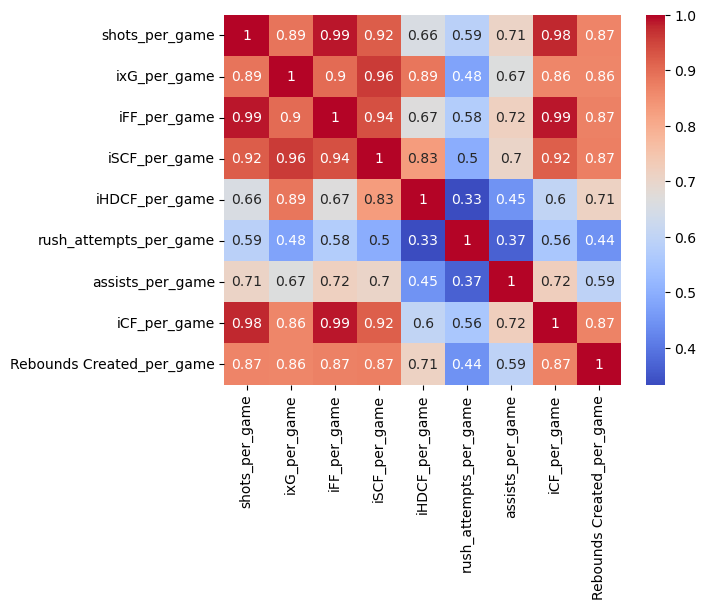

In [54]:
sns.heatmap(X.corr(), annot=True, cmap='coolwarm')
plt.show()

In [97]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]

In [99]:
vif_data["VIF"]

0     337.878556
1     185.748406
2    1050.725902
3     213.019931
4      75.329099
5       8.601710
6       9.126426
7     607.461858
8      32.410381
Name: VIF, dtype: float64

In [107]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)  # Choose the number of components
principal_components = pca.fit_transform(merged_clutch_goals[x_var])
pca_df = pd.DataFrame(principal_components, columns=['PC1', 'PC2'])

In [113]:
print(pca.explained_variance_ratio_)

[0.95414673 0.03201966]


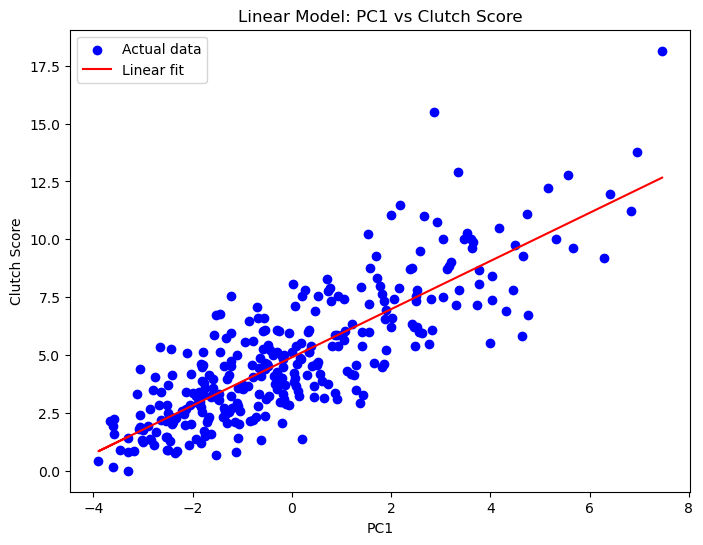

In [117]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming your data is in pca_df and you want to predict clutch_score from PC1 or PC2

# Create a linear regression model
model = LinearRegression()

# Fit the model (you can choose PC1 or PC2 as the predictor variable)
model.fit(pca_df[['PC1']], y)  # assuming 'y' is your target variable (clutch_score)

# Make predictions
y_pred = model.predict(pca_df[['PC1']])

# Plotting
plt.figure(figsize=(8, 6))

# Scatter plot of the data points
plt.scatter(pca_df['PC1'], y, color='blue', label='Actual data')

# Plot the linear regression line
plt.plot(pca_df['PC1'], y_pred, color='red', label='Linear fit')

# Labels and title
plt.xlabel('PC1')
plt.ylabel('Clutch Score')
plt.title('Linear Model: PC1 vs Clutch Score')
plt.legend()

# Show plot
plt.show()


In [41]:
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.svm import SVR 
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

x_var = ['shots_per_game', 'ixG_per_game', 'iFF_per_game', 'iSCF_per_game', 'iHDCF_per_game', 'rush_attempts_per_game', 'assists_per_game', 'iCF_per_game', 'Rebounds Created_per_game']
X_adjusted = merged_clutch_goals[x_var]
y_var = 'clutch_score'  
y = merged_clutch_goals[y_var]

train_x, test_x, train_y, test_y = train_test_split(
    X_adjusted, 
    y, 
    test_size=0.2, 
    random_state=1111
)

xgb_model = XGBRegressor(n_estimators = 100)
xgb_model.fit(train_x, train_y)
kf = KFold(n_splits=10)

scoring = ['neg_root_mean_squared_error', 'r2', 'neg_mean_absolute_error']
scores = cross_validate(xgb_model, train_x, train_y, cv=kf, scoring=scoring)

df_scores = pd.DataFrame.from_dict(scores)
print("Cross-validation Results:")
print(df_scores.mean())

Cross-validation Results:
fit_time                            0.133343
score_time                          0.011370
test_neg_root_mean_squared_error   -1.959585
test_r2                             0.454953
test_neg_mean_absolute_error       -1.504769
dtype: float64


In [167]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, cross_validate
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Load the data
x_var = ['shots', 'ixG', 'iFF', 'iSCF', 'iHDCF', 'rush_attempts', 'assists', 'iCF', 'Rebounds Created']
X_adjusted = merged_clutch_goals[x_var]
y_var = 'clutch_score'
y = merged_clutch_goals[y_var]

# Define the quantiles you want to model
quantiles = [0.5, 0.75, 0.9]

# Set up cross-validation
kf = KFold(n_splits=10, random_state=42, shuffle=True)

# Initialize a dictionary to store the results
results = {}

# Perform cross-validation for each quantile
for q in quantiles:
    model = GradientBoostingRegressor(loss='quantile', alpha=q, n_estimators=100)
    scores = cross_validate(model, X_adjusted, y, cv=kf, scoring=['neg_root_mean_squared_error', 'r2', 'neg_mean_absolute_error'])
    results[f'Quantile {q}'] = {
        'RMSE': -scores['test_neg_root_mean_squared_error'].mean(),
        'R2': scores['test_r2'].mean(),
        'MAE': -scores['test_neg_mean_absolute_error'].mean()
    }

# Print the results
for quantile, metrics in results.items():
    print(f"{quantile}:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.3f}")

Quantile 0.5:
  RMSE: 1.692
  R2: 0.616
  MAE: 1.265
Quantile 0.75:
  RMSE: 1.864
  R2: 0.515
  MAE: 1.495
Quantile 0.9:
  RMSE: 2.383
  R2: 0.197
  MAE: 2.029


In [149]:
from skopt import BayesSearchCV
import xgboost as xgb
import time
import math
from skopt.space import Integer, Real
from scipy.stats import randint, uniform
from skopt.space import Real, Integer, Categorical

from skopt.space import Integer, Real

param_grid = {
    'n_estimators': Integer(100, 150),              # Number of trees/estimators
    'learning_rate': Real(0.01, 0.02),               # Controls the learning rate
    'max_depth': Integer(2, 5),                      # Maximum depth of each tree
    'min_samples_split': Integer(2, 10),             # Minimum number of samples required to split an internal node
    'subsample': Real(0.7, 1),                       # Fraction of samples used for fitting each tree
    'alpha': Real(0.5, 0.9)                          # Quantile regression (controls quantile for loss)
}

def learning_rate_schedule(iteration):
    return 0.1 * (0.99 ** iteration)

# Modified fit parameters
fit_params = {
    'early_stopping_rounds': 35,  # More aggressive stopping
}

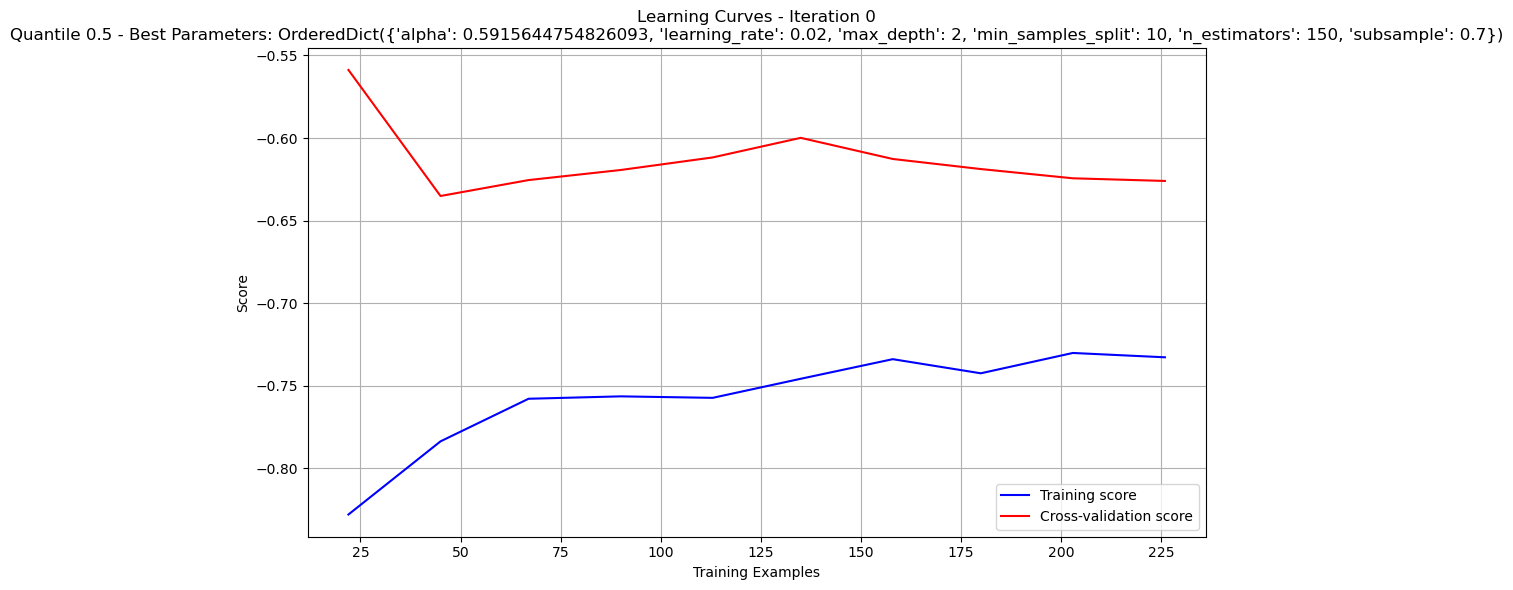

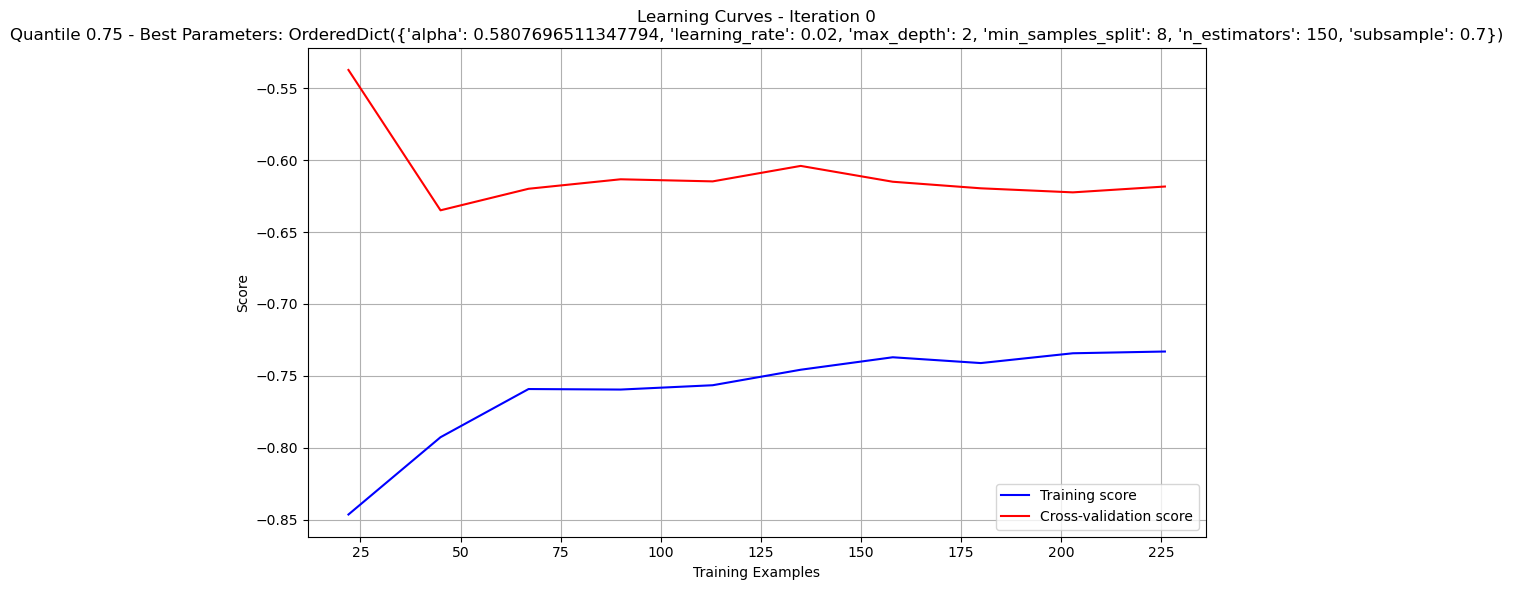

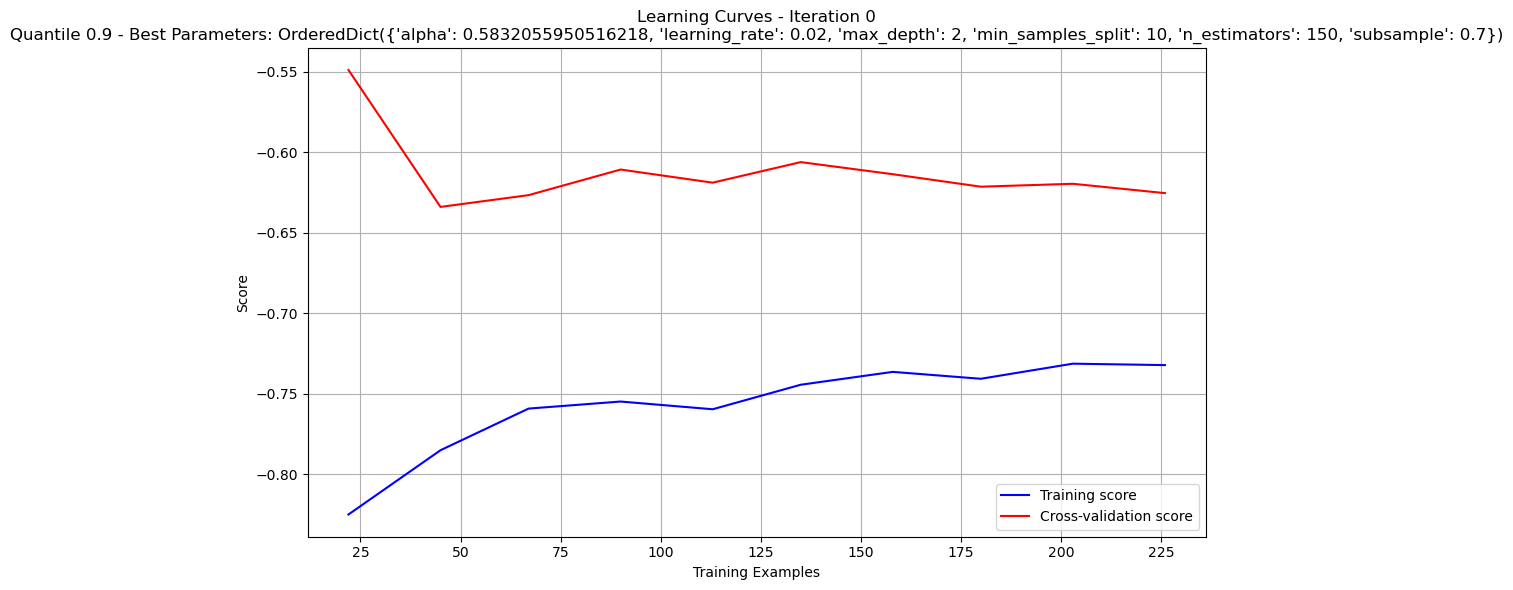

In [151]:
for quantile in [0.5, 0.75, 0.9]:
    random_search = BayesSearchCV(
        GradientBoostingRegressor(loss='quantile', alpha=quantile),
        param_grid,
        cv=kf,
        n_iter=20,
        scoring='neg_root_mean_squared_error',
        refit='neg_root_mean_squared_error',
        n_jobs=-1,
        random_state=1111
    )
    random_search.fit(train_x, train_y)
    xgb_best_model = random_search.best_estimator_
    
    # Plotting learning curves
    title = f'Quantile {quantile} - Best Parameters: {random_search.best_params_}'
    plot_learning_curves(xgb_best_model, train_x, train_y, kf, _, title)
    
    # Predictions on test set
    y_pred = xgb_best_model.predict(test_x)
    
    # Calculate regression metrics
    mse = mean_squared_error(test_y, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(test_y, y_pred)
    r2 = r2_score(test_y, y_pred)
    
    # Append the results
    mse_list.append(mse)
    rmse_list.append(rmse)
    mae_list.append(mae)
    r2_list.append(r2)
    best_hyperparams_list.append(random_search.best_params_)

In [163]:
print(rmse_list)

[1.5766448658907872, 1.56581348430113, 1.597198092900572]


In [165]:
results = pd.DataFrame({'Player': merged_clutch_goals.loc[test_y.index, 'Player'], 'Actual': test_y, 'Predicted': y_pred})

# Calculate the absolute error between predicted and actual values
results['Error'] = abs(results['Actual'] - results['Predicted'])
results.sort_values(by=['Error'], inplace = True, ascending = False)

# Print all results
print("All predictions and actual values:")
print(results.head(50))

All predictions and actual values:
                Player  Actual  Predicted     Error
138       Sam Reinhart   15.49   8.947765  6.542235
150     David Pastrnak   13.78   9.721809  4.058191
197    Kirill Kaprizov   12.80   9.390459  3.409541
68    Vincent Trocheck    6.10   9.265439  3.165439
116         Miles Wood    1.35   4.326576  2.976576
295        Tim Stützle    4.67   7.146637  2.476637
58        Tyler Seguin    6.91   4.466972  2.443028
80      Mark Scheifele    7.57   5.349943  2.220057
10        Trevor Lewis    1.71   3.799569  2.089569
147       Robby Fabbri    5.15   3.234710  1.915290
31        John Tavares    7.38   9.283488  1.903488
61          Bryan Rust    8.71   6.807351  1.902649
214        Noah Gregor    1.43   3.119208  1.689208
47       Tyler Toffoli    6.20   7.836657  1.636657
5         Anze Kopitar    5.93   4.313906  1.616094
81      Sean Couturier    3.38   4.875342  1.495342
298    Alexander Holtz    5.12   3.638159  1.481841
174  Christian Fischer    1.3

In [43]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.svm import SVR  # Importing Support Vector Regression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Define features and target variable
x_var = ['shots_per_game', 'ixG_per_game', 'iFF_per_game', 'iSCF_per_game', 'iHDCF_per_game', 'rush_attempts_per_game', 'assists_per_game', 'iCF_per_game', 'Rebounds Created_per_game']
X_adjusted = merged_clutch_goals[x_var]
y_var = 'clutch_score'  # Predict the continuous clutch score directly
y = merged_clutch_goals[y_var]

# Split the data into train and test sets
train_x, test_x, train_y, test_y = train_test_split(
    X_adjusted, 
    y, 
    test_size=0.2, 
    random_state=250
)

# Initialize the SVR model (using a radial basis function kernel)
svr_model = SVR(kernel='rbf', C=100, epsilon=0.1)

# Fit the model on the training set
svr_model.fit(train_x, train_y)

# Perform cross-validation using KFold
kf = KFold(n_splits=10)

# Define the regression metrics for evaluation
scoring = ['neg_root_mean_squared_error', 'r2', 'neg_mean_absolute_error']

# Cross-validate the model (on the entire dataset)
scores = cross_validate(svr_model, train_x, train_y, cv=kf, scoring=scoring)

# Convert the scores into a DataFrame for easier analysis
df_scores = pd.DataFrame.from_dict(scores)

# Print the mean scores for each metric
print("Cross-validation Results:")
print(df_scores.mean())


Cross-validation Results:
fit_time                            0.009278
score_time                          0.004192
test_neg_root_mean_squared_error   -1.495871
test_r2                             0.723104
test_neg_mean_absolute_error       -1.139185
dtype: float64


In [255]:
from skopt import BayesSearchCV
from sklearn.svm import SVR
from skopt.space import Real, Integer, Categorical
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

def plot_learning_curves(estimator, X, y, cv, iteration, title):

    train_sizes = np.linspace(0.1, 1.0, 10)
    
    # Calculate learning curves
    train_sizes, train_scores, valid_scores = learning_curve(
        estimator, X, y, 
        cv=cv,
        n_jobs=-1,
        train_sizes=train_sizes,
        scoring='neg_log_loss'
    )

    # Calculate mean and std
    train_mean = -np.mean(train_scores, axis=1)
    train_std = -np.std(train_scores, axis=1)
    valid_mean = -np.mean(valid_scores, axis=1)
    valid_std = -np.std(valid_scores, axis=1)
    
    # Plot learning curves
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, label='Training score', color='blue')
    
    plt.plot(train_sizes, valid_mean, label='Cross-validation score', color='red')
    
    plt.title(f'Learning Curves - Iteration {iteration}\n{title}')
    plt.xlabel('Training Examples')
    plt.ylabel('Score')
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()


# Define features and target variable
x_var = ['shots_per_game', 'ixG_per_game', 'iFF_per_game', 'iSCF_per_game', 'iHDCF_per_game', 'rush_attempts_per_game', 'assists_per_game', 'iCF_per_game', 'Rebounds Created_per_game']
X_adjusted = merged_clutch_goals[x_var]
y_var = 'clutch_score'  
y = merged_clutch_goals[y_var]

train_x, test_x, train_y, test_y = train_test_split(
    X_adjusted, 
    y, 
    test_size=0.2, 
    random_state=1111
)

# Define the hyperparameter search space for SVR
param_grid_svr = {
    'C': Real(0.1, 100, prior='log-uniform'),        # Regularization parameter
    'epsilon': Real(0.01, 0.3),                      # Epsilon (the margin of tolerance)
    'kernel': Categorical(['poly']), # Kernel type
    'degree': Integer(1, 1.5),                          # Degree of the polynomial kernel (if 'poly')
    'gamma': Categorical(['scale'])           # Kernel coefficient for 'rbf', 'poly', and 'sigmoid'
}

# Initialize the SVR model
svr_model = SVR()

kf = KFold(n_splits=10)


# Use BayesSearchCV for hyperparameter optimization
bayes_search_svr = BayesSearchCV(
    svr_model,                 # Model to optimize
    param_grid_svr,            # Hyperparameter search space
    n_iter=10,                 # Number of iterations for optimization
    cv=kf,                      # Cross-validation splits
    n_jobs=-1,                 # Use all available processors
    random_state=42            # For reproducibility
)

# Fit the model to the data
bayes_search_svr.fit(train_x, train_y)

#plot_learning_curves(bayes_search_svr, train_x, train_y, kf, 1, 'Curve')


# Print the best hyperparameters
print(f"Best hyperparameters: {bayes_search_svr.best_params_}")

# Optionally, you can use the best model for prediction and evaluation
best_svr_model = bayes_search_svr.best_estimator_
y_pred = best_svr_model.predict(test_x)

# Calculate and print regression metrics (for evaluation)
mse = mean_squared_error(test_y, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_y, y_pred)
r2 = r2_score(test_y, y_pred)

print(f"Test Set MSE: {mse}")
print(f"Test Set RMSE: {rmse}")
print(f"Test Set MAE: {mae}")
print(f"Test Set R²: {r2}")


Best hyperparameters: OrderedDict({'C': 73.52481813242629, 'degree': 1, 'epsilon': 0.26277905925433237, 'gamma': 'scale', 'kernel': 'poly'})
Test Set MSE: 2.4532689578422833
Test Set RMSE: 1.566291466439846
Test Set MAE: 1.0832859589260786
Test Set R²: 0.7025452799890533


In [257]:
1 - (1-best_svr_model.score(train_x, train_y))*(len(train_y)-1)/(len(train_y)-train_x.shape[1]-1)

0.7057011064662266

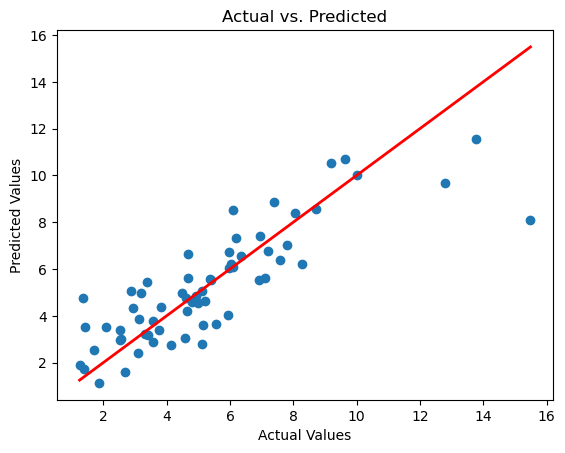

In [259]:
import matplotlib.pyplot as plt
import numpy as np

y_pred = best_svr_model.predict(test_x)  
y_test = test_y  

# Scatter plot of Actual vs Predicted
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)  # Ideal line (y = x)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted')
plt.show()

In [261]:
results = pd.DataFrame({'Player': merged_clutch_goals.loc[test_y.index, 'Player'], 'Actual': test_y, 'Predicted': y_pred})

# Calculate the absolute error between predicted and actual values
results['Error'] = abs(results['Actual'] - results['Predicted'])
results.sort_values(by=['Error'], inplace = True, ascending = False)

# Print all results
print("All predictions and actual values:")
print(results.head(50))

All predictions and actual values:
                Player  Actual  Predicted     Error
138       Sam Reinhart   15.49   8.078963  7.411037
116         Miles Wood    1.35   4.741434  3.391434
197    Kirill Kaprizov   12.80   9.673601  3.126399
68    Vincent Trocheck    6.10   8.540030  2.440030
298    Alexander Holtz    5.12   2.796557  2.323443
150     David Pastrnak   13.78  11.563935  2.216065
307     Cole Sillinger    2.86   5.057863  2.197863
214        Noah Gregor    1.43   3.537454  2.107454
291        Seth Jarvis    8.27   6.198389  2.071611
81      Sean Couturier    3.38   5.435413  2.055413
295        Tim Stützle    4.67   6.649018  1.979018
191    Anthony Cirelli    5.57   3.635698  1.934302
5         Anze Kopitar    5.93   4.028259  1.901741
46        Jason Zucker    3.19   4.956466  1.766466
147       Robby Fabbri    5.15   3.616035  1.533965
290        Ridly Greig    4.58   3.052045  1.527955
128       Sean Monahan    7.11   5.612165  1.497835
31        John Tavares    7.3

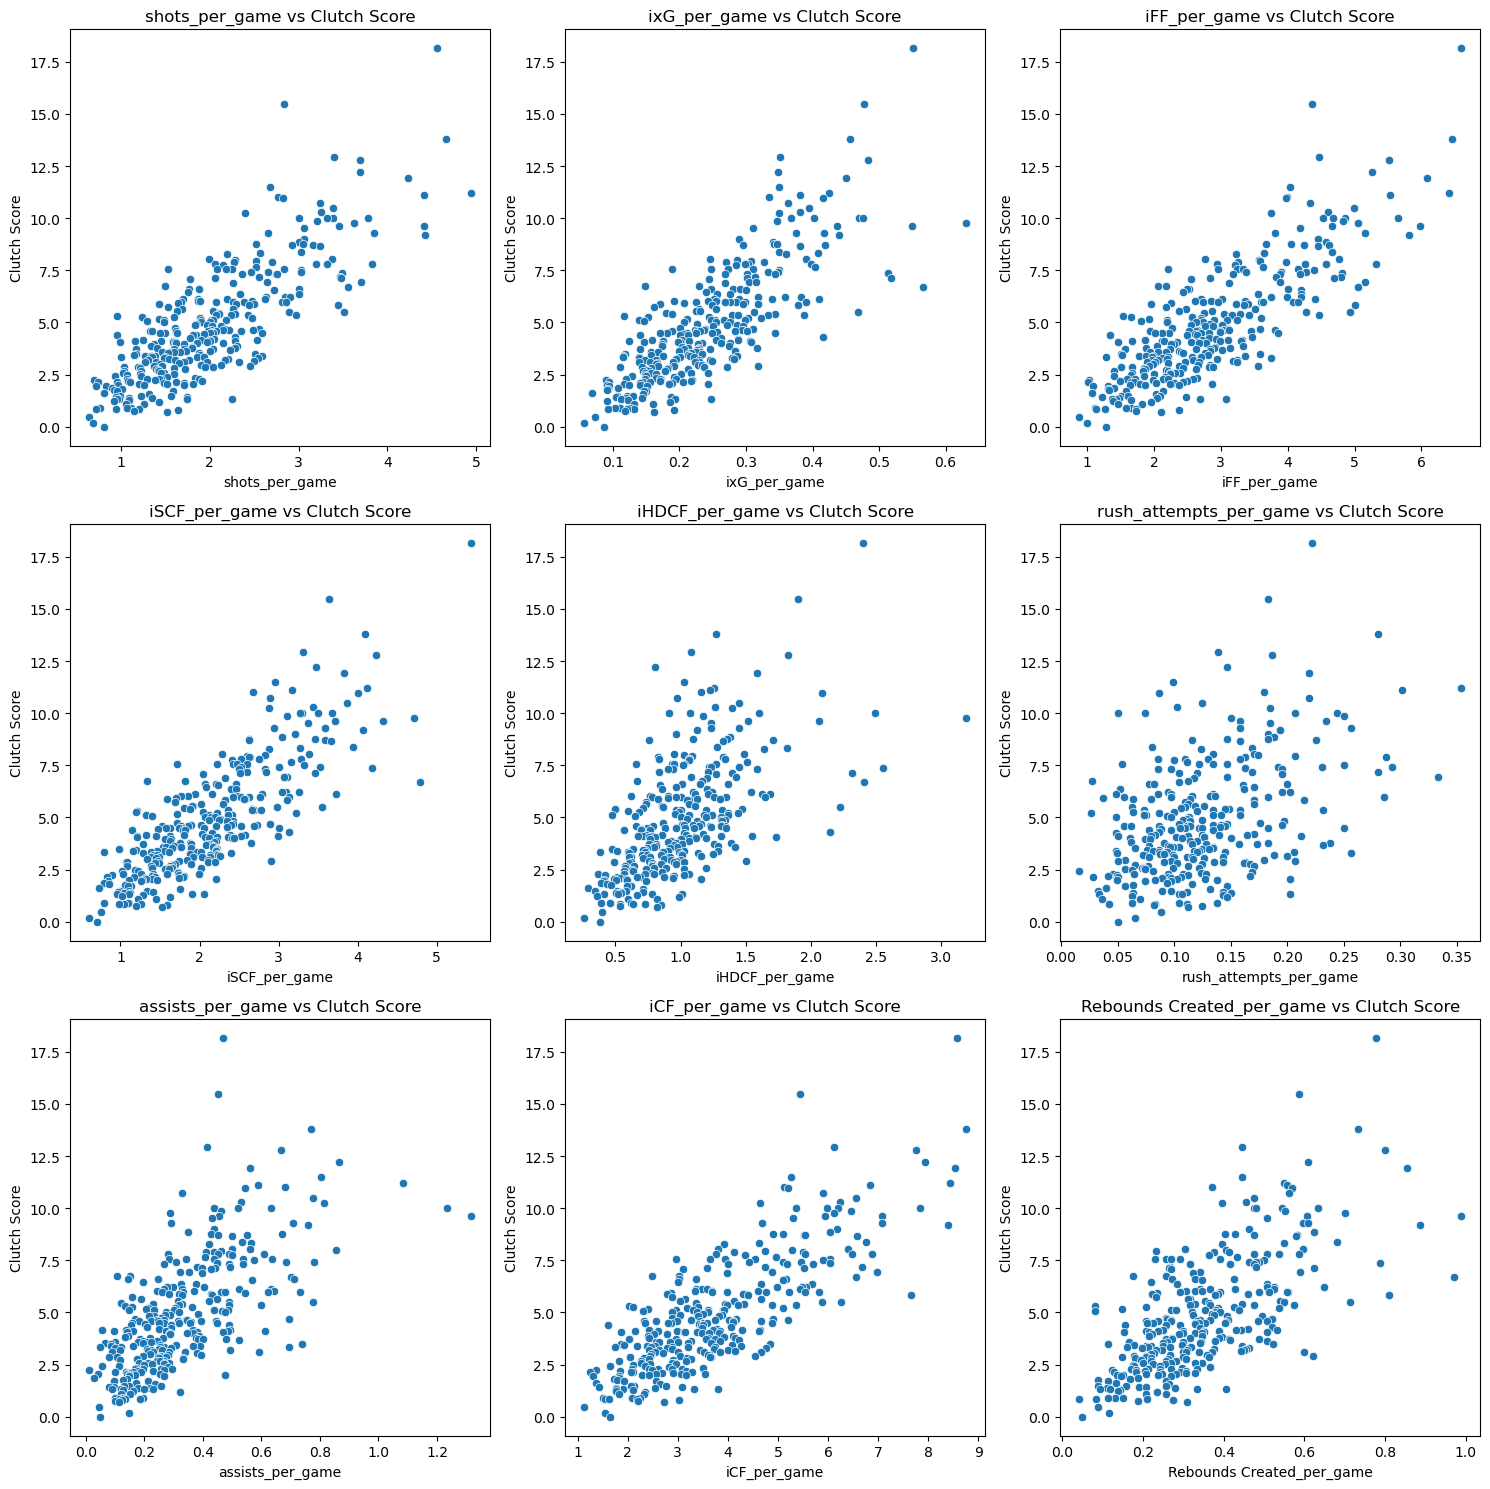

In [183]:
import matplotlib.pyplot as plt
import seaborn as sns

num_features = len(X_adjusted.columns)  # Number of features in X_adjusted
fig, axes = plt.subplots(nrows=(num_features + 2) // 3, ncols=3, figsize=(15, 5 * ((num_features + 2) // 3)))

# Flatten axes to make it easier to loop over them
axes = axes.flatten()

# Iterate through each feature in X_adjusted and plot against the target variable y (clutch_score)
for i, feature in enumerate(X_adjusted.columns):
    sns.scatterplot(x=X_adjusted[feature], y=y, ax=axes[i])
    axes[i].set_title(f'{feature} vs Clutch Score')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Clutch Score')

# Remove any unused axes if the number of features is less than the number of subplots
for i in range(num_features, len(axes)):
    axes[i].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()


In [189]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Assuming merged_clutch_goals is your dataset and already loaded

# Define the feature columns and target
x_var = ['shots_per_game', 'ixG_per_game', 'iFF_per_game', 'iSCF_per_game', 'iHDCF_per_game', 
         'rush_attempts_per_game', 'assists_per_game', 'iCF_per_game', 'Rebounds Created_per_game']
X_adjusted = merged_clutch_goals[x_var]
y_var = 'clutch_score'  # Predict the continuous clutch score directly
y = merged_clutch_goals[y_var]

# Split the data into train and test sets
train_x, test_x, train_y, test_y = train_test_split(
    X_adjusted, 
    y, 
    test_size=0.2, 
    random_state=200
)

degree = 1  # Degree of the polynomial features (you can change this to 3, 4, etc.)
poly = PolynomialFeatures(degree)

# Transform the training and test sets to include polynomial features
train_x_poly = poly.fit_transform(train_x)
test_x_poly = poly.transform(test_x)

# Initialize and train a linear regression model on the polynomial features
model = LinearRegression()
model.fit(train_x_poly, train_y)

# Make predictions on the test set
test_y_pred = model.predict(test_x_poly)

# Evaluate the model using R-squared and Mean Squared Error
r2 = r2_score(test_y, test_y_pred)
mse = mean_squared_error(test_y, test_y_pred)

# Output the evaluation metrics
print(f"R-squared: {r2}")
print(f"Mean Squared Error: {mse}")


R-squared: 0.6468318669604707
Mean Squared Error: 2.568629829935421


In [319]:
import numpy as np
from sklearn.linear_model import RANSACRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# Assuming you have X_adjusted and y from your previous setup
X_train, X_test, y_train, y_test = train_test_split(X_adjusted, y, test_size=0.2, random_state=1111)

# Define the parameter grid
param_grid = {
    'min_samples': [0.1, 0.2, 0.5, 0.8],  # Fraction of points used to fit the model
    'residual_threshold': [0.2, 0.3],  # Maximum distance from model to be an inlier
    'max_trials': [100, 300, 700],  # Number of trials for RANSAC
}

# Initialize RANSAC model
ransac = RANSACRegressor(random_state=42)

# Perform GridSearchCV
grid_search = GridSearchCV(ransac, param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
print(f"Best Parameters: {grid_search.best_params_}")

# Evaluate the best model on the test set
best_ransac = grid_search.best_estimator_
y_pred = best_ransac.predict(X_test)

# Evaluate the performance (you can use metrics like MAE, MSE, etc.)
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error of the best RANSAC model: {mse}")


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters: {'max_trials': 100, 'min_samples': 0.8, 'residual_threshold': 0.2}
Mean Squared Error of the best RANSAC model: 2.342080738929251


In [327]:
from sklearn.ensemble import IsolationForest

# Initialize Isolation Forest model
iso_forest = IsolationForest(contamination=0.05, random_state=42)  # Assume 5% of data is outliers

# Fit the model to detect outliers
outlier_pred = iso_forest.fit_predict(X_adjusted)

# The prediction is 1 for inliers, -1 for outliers
is_inlier = outlier_pred == 1
is_outlier = outlier_pred == -1

# Separate the inliers and outliers
X_inliers = X_adjusted[is_inlier]
y_inliers = y[is_inlier]
X_outliers = X_adjusted[is_outlier]
y_outliers = y[is_outlier]

Outliers based on Cook's Distance:
                    Player  Actual  Predicted  Cook's Distance
205        Auston Matthews   18.15  12.650371         0.196021
138           Sam Reinhart   15.49   8.985729         0.111395
166            Kyle Connor   12.92   9.394983         0.038169
197        Kirill Kaprizov   12.80  10.150359         0.018503
193         Artemi Panarin   12.20  10.038643         0.020440
96          Filip Forsberg   11.95   9.459946         0.026897
139         Leon Draisaitl   11.48   8.451565         0.022253
124       Nathan MacKinnon   11.22  12.638992         0.017653
169            Jack Eichel   11.11   9.413764         0.020718
173          Sebastian Aho   11.03   7.805689         0.012835
156          Brayden Point   10.99   8.454877         0.022035
88   Jonathan Marchessault   10.73   8.185482         0.019408
82             J.T. Miller   10.25   7.439649         0.021521
36           Chris Kreider   10.00   8.445672         0.013978
28           Kyle Pa

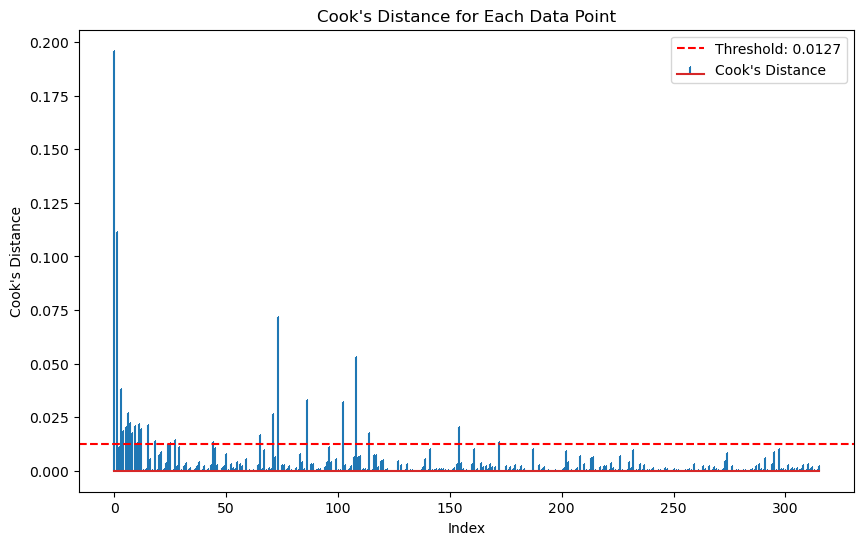

In [363]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Assuming your data is already loaded into X_adjusted and y
# X_adjusted = merged_clutch_goals[x_var]
# y = merged_clutch_goals[y_var]

# Step 1: Fit a Linear Regression model using Statsmodels
X_with_intercept = sm.add_constant(X_adjusted)  # Add intercept to the features (X)
model = sm.OLS(y, X_with_intercept).fit()  # Fit the model

# Step 2: Get Cook's Distance
# Cook's distance is available through the influence() method in statsmodels
influence = model.get_influence()
cooks_d, _ = influence.cooks_distance

# Step 3: Identify influential points (outliers)
# Typically, a Cook's Distance greater than 4/n (where n is the number of data points) is considered influential
threshold = 4 / len(X_adjusted)
outliers = np.where(cooks_d > threshold)[0]

# Step 4: Create a DataFrame to show the results
results = pd.DataFrame({
    'Player': merged_clutch_goals.loc[y.index, 'Player'],
    'Actual': y,
    'Predicted': model.fittedvalues,
    'Cook\'s Distance': cooks_d
})

# Sort by Cook's Distance to display the most influential points (outliers)
outliers_df = results.iloc[outliers]

# Print out the outliers
print("Outliers based on Cook's Distance:")
print(outliers_df)

# Optional: Visualize Cook's Distance
plt.figure(figsize=(10, 6))
plt.stem(cooks_d, markerfmt=",", label="Cook's Distance")
plt.axhline(y=threshold, color='r', linestyle='--', label=f"Threshold: {threshold:.4f}")
plt.xlabel('Index')
plt.ylabel("Cook's Distance")
plt.title("Cook's Distance for Each Data Point")
plt.legend()
plt.show()


In [365]:
threshold = 4 / len(X_adjusted)  # Calculate threshold based on the number of data points
outliers_df = results[results["Cook's Distance"] > threshold]

# Display outliers based on Cook's Distance threshold
print("Outliers based on Cook's Distance:")
print(outliers_df)

Outliers based on Cook's Distance:
                    Player  Actual  Predicted  Cook's Distance
205        Auston Matthews   18.15  12.650371         0.196021
138           Sam Reinhart   15.49   8.985729         0.111395
166            Kyle Connor   12.92   9.394983         0.038169
197        Kirill Kaprizov   12.80  10.150359         0.018503
193         Artemi Panarin   12.20  10.038643         0.020440
96          Filip Forsberg   11.95   9.459946         0.026897
139         Leon Draisaitl   11.48   8.451565         0.022253
124       Nathan MacKinnon   11.22  12.638992         0.017653
169            Jack Eichel   11.11   9.413764         0.020718
173          Sebastian Aho   11.03   7.805689         0.012835
156          Brayden Point   10.99   8.454877         0.022035
88   Jonathan Marchessault   10.73   8.185482         0.019408
82             J.T. Miller   10.25   7.439649         0.021521
36           Chris Kreider   10.00   8.445672         0.013978
28           Kyle Pa

                            OLS Regression Results                            
Dep. Variable:           clutch_score   R-squared:                       0.380
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     1.089
Date:                Wed, 06 Nov 2024   Prob (F-statistic):              0.422
Time:                        11:58:33   Log-Likelihood:                -62.424
No. Observations:                  26   AIC:                             144.8
Df Residuals:                      16   BIC:                             157.4
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

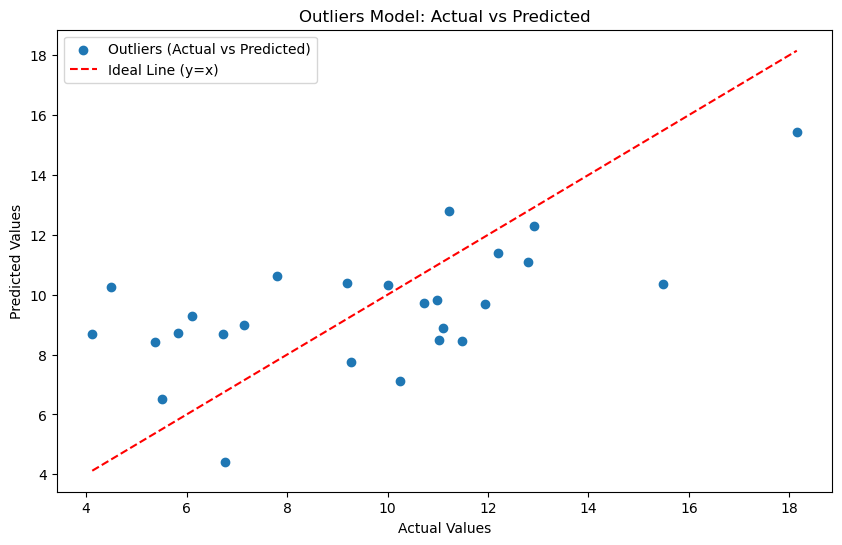

In [367]:
# Step 1: Extract the outliers based on Cook's Distance
outliers_data = X_adjusted.iloc[outliers]  # Extract the feature set for the outliers
outliers_target = y.iloc[outliers]          # Extract the target variable for the outliers

# Step 2: Add intercept to the outlier features (as we did for the original model)
X_with_intercept_outliers = sm.add_constant(outliers_data)  # Add intercept to the outlier features

# Step 3: Train a new model using the outliers data
outliers_model = sm.OLS(outliers_target, X_with_intercept_outliers).fit()

# Step 4: Print the summary of the outliers model
print(outliers_model.summary())

# Step 5: Visualize the fitted values for outliers model
plt.figure(figsize=(10, 6))
plt.scatter(outliers_target, outliers_model.fittedvalues, label='Outliers (Actual vs Predicted)')
plt.plot([outliers_target.min(), outliers_target.max()], [outliers_target.min(), outliers_target.max()], color='red', linestyle='--', label='Ideal Line (y=x)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Outliers Model: Actual vs Predicted')
plt.legend()
plt.show()


In [371]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt

# Assuming your features and target variable are ready
# X_adjusted = merged_clutch_goals[x_var]
# y = merged_clutch_goals[y_var]

# Step 1: Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_adjusted)

# Step 2: Build the Neural Network Model
model = Sequential()

# Input layer (size of input features)
model.add(Dense(64, input_dim=X_scaled.shape[1], activation='relu'))  # Hidden layer with 64 nodes and ReLU activation
model.add(Dense(32, activation='relu'))  # Another hidden layer with 32 nodes
model.add(Dense(1))  # Output layer (single continuous output)

# Step 3: Compile the Model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Step 4: Train the Model
history = model.fit(X_scaled, y, epochs=100, batch_size=4, verbose=1)

# Step 5: Evaluate the model
y_pred = model.predict(X_scaled)

# Plot the training history (Loss and MAE)
plt.figure(figsize=(12, 6))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.title("Training Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Plot training MAE (Mean Absolute Error)
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.title("Training MAE (Mean Absolute Error)")
plt.xlabel('Epochs')
plt.ylabel('MAE')

plt.tight_layout()
plt.show()

# Step 6: Compare predicted vs actual clutch scores
results = pd.DataFrame({
    'Player': merged_clutch_goals['Player'],
    'Actual': y,
    'Predicted': y_pred.flatten()
})

# Print a sample of the results
print(results.head())

# Plot predicted vs actual
plt.figure(figsize=(8, 6))
plt.scatter(results['Actual'], results['Predicted'])
plt.plot([results['Actual'].min(), results['Actual'].max()],
         [results['Actual'].min(), results['Actual'].max()],
         color='red', lw=2, label='Ideal Line (y=x)')
plt.xlabel('Actual Clutch Score')
plt.ylabel('Predicted Clutch Score')
plt.title('Actual vs Predicted Clutch Scores')
plt.legend()
plt.show()


ModuleNotFoundError: No module named 'tensorflow'

In [41]:
correlation = X_adjusted.corrwith(y)  # Calculate correlation of each feature with target
print(correlation)

NameError: name 'y' is not defined

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


C:\Users\jivrajs3\AppData\Local\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(


Best Hyperparameters: {'activation': 'relu', 'alpha': 0.01, 'batch_size': 32, 'hidden_layer_sizes': (128, 64), 'learning_rate': 'constant', 'solver': 'sgd'}


C:\Users\jivrajs3\AppData\Local\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jivrajs3\AppData\Local\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jivrajs3\AppData\Local\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jivrajs3\AppData\Local\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\U

Cross-validation MSE scores: [-1.71380606 -2.25432644 -1.57006536 -2.05519639 -3.03518662]
Mean cross-validation MSE: -2.1257


C:\Users\jivrajs3\AppData\Local\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(


Train MSE: 1.4531, Test MSE: 2.4294
Train MAE: 0.9280, Test MAE: 1.2374
                 Player  Actual  Predicted
16   James van Riemsdyk    4.08   4.792625
61           Bryan Rust    8.71   8.981123
146       Nick Schmaltz    4.18   5.070078
73         Brandon Saad    6.46   4.315528
245     Drake Batherson    5.98   6.446648


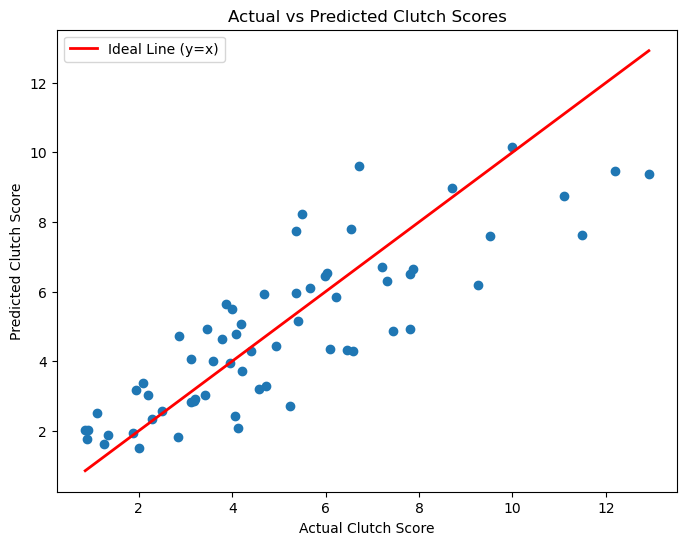

In [379]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Assuming your features (X_adjusted) and target variable (y) are ready
# X_adjusted = merged_clutch_goals[x_var]
# y = merged_clutch_goals[y_var]

# Step 1: Split the data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_adjusted, y, test_size=0.2, random_state=42)

# Step 2: Normalize the features (standardize data)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit and transform on training data
X_test_scaled = scaler.transform(X_test)  # Only transform on test data (to avoid data leakage)

# Step 3: Define the Neural Network Model (MLPRegressor)
model = MLPRegressor(max_iter=150, random_state=42)

# Step 4: Hyperparameter Tuning using GridSearchCV
param_grid = {
    'hidden_layer_sizes': [(64, 32), (128, 64), (256, 128)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'learning_rate': ['constant', 'adaptive'],
    'alpha': [0.0001, 0.001, 0.01],  # Regularization parameter
    'batch_size': [32, 64, 128]
}

# GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)

# Step 5: Fit the model using GridSearchCV
grid_search.fit(X_train_scaled, y_train)

# Best hyperparameters from GridSearchCV
best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")

# Step 6: Get the best model from the grid search
best_model = grid_search.best_estimator_

# Step 7: Cross-validation to check the robustness of the model
cv_scores = cross_val_score(best_model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')

# Print cross-validation results
print(f"Cross-validation MSE scores: {cv_scores}")
print(f"Mean cross-validation MSE: {cv_scores.mean():.4f}")

# Step 8: Train the best model on the full training data
best_model.fit(X_train_scaled, y_train)

# Step 9: Make predictions
y_pred_train = best_model.predict(X_train_scaled)
y_pred_test = best_model.predict(X_test_scaled)

# Step 10: Evaluate the Model
train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)

train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred_test)

print(f"Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}")
print(f"Train MAE: {train_mae:.4f}, Test MAE: {test_mae:.4f}")

# Step 11: Compare predicted vs actual values (for test data)
results = pd.DataFrame({
    'Player': merged_clutch_goals.loc[y_test.index, 'Player'],
    'Actual': y_test,
    'Predicted': y_pred_test
})

# Print a sample of the results
print(results.head())

# Step 12: Plot predicted vs actual for the test set
plt.figure(figsize=(8, 6))
plt.scatter(results['Actual'], results['Predicted'])
plt.plot([results['Actual'].min(), results['Actual'].max()],
         [results['Actual'].min(), results['Actual'].max()],
         color='red', lw=2, label='Ideal Line (y=x)')
plt.xlabel('Actual Clutch Score')
plt.ylabel('Predicted Clutch Score')
plt.title('Actual vs Predicted Clutch Scores')
plt.legend()
plt.show()


In [351]:
merged_clutch_goals.loc[150]

playerId                                   8477956
Player                              David Pastrnak
positionCode                                     R
gamesPlayed                                     82
assists                                         63
ot_goals                                         0
game_winning_goals                               5
regulation_game_winning                          5
goals_up_by_one                                 12
goals_down_by_one                                8
goals_when_tied                                 20
total_goals                                     47
shots                                          382
ixG                                          37.37
iFF                                            530
iSCF                                           336
iHDCF                                          104
rush_attempts                                   23
iCF                                            718
Rebounds Created               

In [329]:
X_outliers

,shots_per_game,ixG_per_game,iFF_per_game,iSCF_per_game,iHDCF_per_game,rush_attempts_per_game,assists_per_game,iCF_per_game,Rebounds Created_per_game
205,4.555556,0.550741,6.592593,5.432099,2.395062,0.222222,0.469136,8.567901,0.777778
150,4.658537,0.455732,6.463415,4.097561,1.268293,0.280488,0.768293,8.756098,0.731707
197,3.693333,0.483600,5.520000,4.226667,1.826667,0.186667,0.666667,7.760000,0.800000
96,4.231707,0.450488,6.085366,3.829268,1.585366,0.219512,0.560976,8.536585,0.853659
124,4.939024,0.424634,6.414634,4.121951,1.256098,0.353659,1.085366,8.439024,0.548780
75,3.777778,0.402469,5.654321,3.296296,1.074074,0.074074,1.234568,7.839506,0.543210
56,3.625000,0.630500,5.050000,4.712500,3.187500,0.150000,0.287500,6.112500,0.700000
254,4.407407,0.549630,5.987654,4.320988,2.061728,0.234568,0.456790,7.086420,0.987654
168,3.460526,0.436184,4.657895,3.710526,1.513158,0.157895,1.315789,5.947368,0.605263
276,4.419355,0.439839,5.822581,4.064516,1.129032,0.193548,0.758065,8.403226,0.887097


In [353]:
# Train a model on the inliers (regular data)
inlier_model = LinearRegression()
inlier_model.fit(X_inliers, y_inliers)

# Predict on inliers (for evaluation)
y_inliers_pred = inlier_model.predict(X_inliers)

# Evaluate the performance on inliers
mse_inliers = mean_squared_error(y_inliers, y_inliers_pred)
print(f"Mean Squared Error on Inliers: {mse_inliers}")

Mean Squared Error on Inliers: 1.9727003839838657


In [355]:
# Train a model on the outliers (exceptional cases)
outlier_model = RANSACRegressor(random_state=42)
outlier_model.fit(X_outliers, y_outliers)

# Predict on outliers (for evaluation)
y_outliers_pred = outlier_model.predict(X_outliers)

# Evaluate the performance on outliers
mse_outliers = mean_squared_error(y_outliers, y_outliers_pred)
print(f"Mean Squared Error on Outliers: {mse_outliers}")


Mean Squared Error on Outliers: 10.59338059576475


In [361]:
results = pd.DataFrame({
    'Player': merged_clutch_goals.loc[y_inliers.index, 'Player'],
    'Actual': y_inliers,
    'Predicted': y_inliers_pred
})

# Calculate the absolute error between predicted and actual values
results['Error'] = abs(results['Actual'] - results['Predicted'])

# Step 6: Sort the results by Error to view the top outliers
results.sort_values(by=['Error'], inplace=True, ascending=False)

# Print the top outliers
print("Top outliers based on the error for the outlier model:")
print(results.head(50))

Top outliers based on the error for the outlier model:
                    Player  Actual  Predicted     Error
138           Sam Reinhart   15.49   8.942595  6.547405
133         Anthony Mantha    7.57   3.459365  4.110635
223        Michael Carcone    6.76   2.661268  4.098732
166            Kyle Connor   12.92   9.248171  3.671829
278        Simon Holmstrom    5.33   2.179617  3.150383
173          Sebastian Aho   11.03   7.949755  3.080245
116             Miles Wood    1.35   4.430243  3.080243
110       Pavel Buchnevich    4.50   7.577563  3.077563
76     Ryan Nugent-Hopkins    4.12   7.160082  3.040082
139         Leon Draisaitl   11.48   8.722426  2.757574
272         Nils Hoglander    6.75   4.015125  2.734875
57           Ryan Johansen    5.24   2.571783  2.668217
88   Jonathan Marchessault   10.73   8.116115  2.613885
171             Timo Meier    8.84   6.238086  2.601914
82             J.T. Miller   10.25   7.653859  2.596141
298        Alexander Holtz    5.12   2.531630  2.

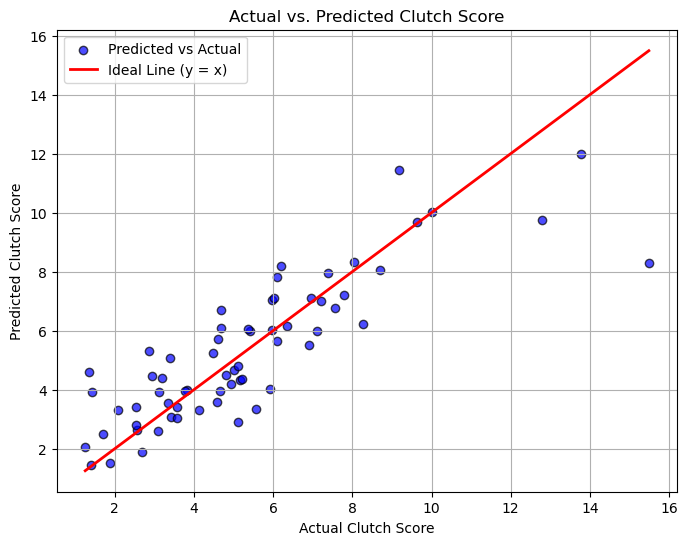

In [320]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7, edgecolors='k', color='b', label='Predicted vs Actual')

# Plot the ideal line (y = x), showing perfect predictions
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2, label='Ideal Line (y = x)')

# Labels and Title
plt.xlabel('Actual Clutch Score')
plt.ylabel('Predicted Clutch Score')
plt.title('Actual vs. Predicted Clutch Score')

# Optional: Add grid for better readability
plt.grid(True)

# Optional: Add legend for clarity
plt.legend(loc='best')

# Show the plot
plt.show()

In [321]:
results = pd.DataFrame({'Player': merged_clutch_goals.loc[y_test.index, 'Player'], 'Actual': y_test, 'Predicted': y_pred})

# Calculate the absolute error between predicted and actual values
results['Error'] = abs(results['Actual'] - results['Predicted'])
results.sort_values(by=['Error'], inplace = True, ascending = False)

# Print all results
print("All predictions and actual values:")
print(results.head(50))

All predictions and actual values:
                Player  Actual  Predicted     Error
138       Sam Reinhart   15.49   8.289645  7.200355
116         Miles Wood    1.35   4.602878  3.252878
197    Kirill Kaprizov   12.80   9.754761  3.045239
214        Noah Gregor    1.43   3.909299  2.479299
307     Cole Sillinger    2.86   5.305825  2.445825
276        Jack Hughes    9.19  11.439743  2.249743
298    Alexander Holtz    5.12   2.890716  2.229284
191    Anthony Cirelli    5.57   3.346943  2.223057
291        Seth Jarvis    8.27   6.217240  2.052760
295        Tim Stützle    4.67   6.684676  2.014676
47       Tyler Toffoli    6.20   8.178975  1.978975
5         Anze Kopitar    5.93   4.008962  1.921038
150     David Pastrnak   13.78  11.972183  1.807817
68    Vincent Trocheck    6.10   7.805374  1.705374
81      Sean Couturier    3.38   5.066625  1.686625
294      Anton Lundell    2.95   4.462629  1.512629
58        Tyler Seguin    6.91   5.498251  1.411749
303     Tyson Foerster    4.6

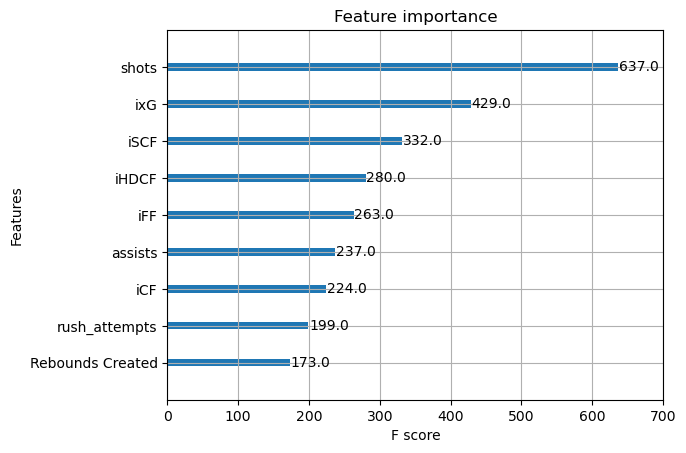

In [539]:
plot_importance(xgb_model_regression)
plt.show()

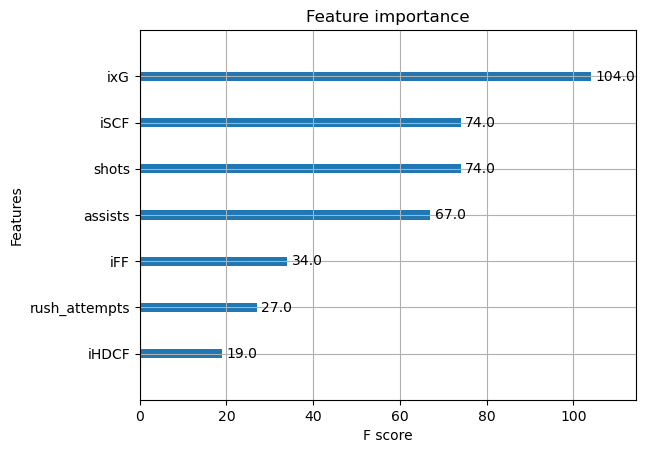

In [543]:
results = pd.DataFrame({'Player': merged_clutch_goals.loc[test_y.index, 'Player'], 'Actual': test_y, 'Predicted': y_pred})

# Calculate the absolute error between predicted and actual values
results['Error'] = abs(results['Actual'] - results['Predicted'])
results.sort_values(by=['Error'], inplace = True, ascending = False)

# Print all results
print("All predictions and actual values:")
print(results.head(50))

All predictions and actual values:
                Player  Actual  Predicted     Error
205    Auston Matthews   18.15   8.408568  9.741432
133     Anthony Mantha    7.57   3.274798  4.295202
150     David Pastrnak   13.78   9.659214  4.120786
203    Matthew Tkachuk    5.50   9.329239  3.829239
96      Filip Forsberg   11.95   8.579214  3.370786
193     Artemi Panarin   12.20   8.941955  3.258045
272     Nils Hoglander    6.75   3.683527  3.066473
287      Lucas Raymond    8.05   5.028583  3.021417
83          Joel Armia    5.45   3.432146  2.017854
295        Tim Stützle    4.67   6.406709  1.736709
291        Seth Jarvis    8.27   6.554093  1.715907
231   Elias Pettersson    8.78   7.206295  1.573705
121       Ryan Hartman    6.35   4.818435  1.531565
177     Travis Konecny    9.87   8.351904  1.518096
189       Jake DeBrusk    3.75   5.221947  1.471947
233        Nick Suzuki    7.56   6.089637  1.470363
237       Morgan Frost    2.96   4.390492  1.430492
142     Nikolaj Ehlers    7.5

In [465]:
merged_clutch_goals.loc[205]

playerId                                    8479318
Player                              Auston Matthews
positionCode                                      C
gamesPlayed                                      81
assists                                          38
ot_goals                                          3
game_winning_goals                                8
regulation_game_winning                           5
goals_up_by_one                                  14
goals_down_by_one                                17
goals_when_tied                                  20
total_goals                                      69
shots                                           369
ixG                                           44.61
iFF                                             534
iSCF                                            440
iHDCF                                           194
rush_attempts                                    18
iCF                                             694
Rebounds Cre

In [161]:
test_y.index

Index([228,  61, 146,  73,  23, 222,  28, 169, 145,  55, 230, 157, 299,   1,
       252,  77,  42, 126, 312, 181, 193, 281, 159, 260, 235,  64, 282, 294,
       113, 136, 112, 295,  31, 263, 201, 153,  34, 166, 202,  94, 255, 198,
        22,  79,  32, 165,  20, 127, 208, 122, 129, 111, 246,  83,  33, 220,
       249, 139, 270, 200, 170,  93, 204, 192],
      dtype='int64')

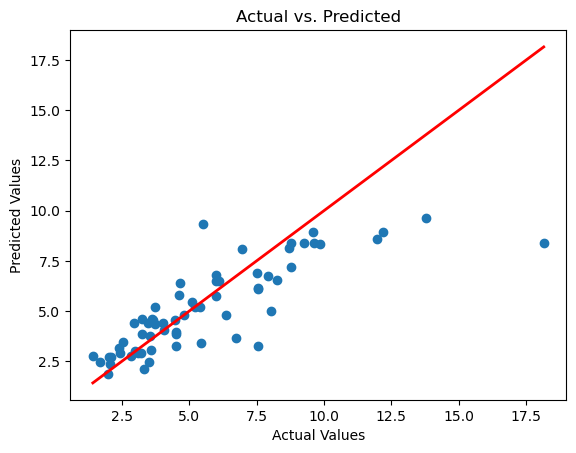

In [545]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have your model's predictions and the actual values
y_pred = xgb_best_model.predict(test_x)  # Replace with your model's predictions
y_test = test_y  # Actual target values

# Scatter plot of Actual vs Predicted
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)  # Ideal line (y = x)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted')
plt.show()

In [213]:
from sklearn.linear_model import RANSACRegressor

ransac = RANSACRegressor()
ransac.fit(train_x, train_y)

kf = KFold(n_splits=10)

# Define the regression metrics for evaluation
scoring = ['neg_root_mean_squared_error', 'r2', 'neg_mean_absolute_error']

# Cross-validate the model (on the entire dataset)
scores = cross_validate(svr_model, train_x, train_y, cv=kf, scoring=scoring)

# Convert the scores into a DataFrame for easier analysis
df_scores = pd.DataFrame.from_dict(scores)

# Print the mean scores for each metric
print("Cross-validation Results:")
print(df_scores.mean())

Cross-validation Results:
fit_time                            0.006787
score_time                          0.003492
test_neg_root_mean_squared_error   -1.683738
test_r2                             0.631715
test_neg_mean_absolute_error       -1.268664
dtype: float64


In [223]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have your model's predictions and the actual values
y_pred = ransac.predict(test_x)  # Replace with your model's predictions
y_test = test_y  # Actual target values

# Scatter plot of Actual vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7, edgecolors='k', color='b', label='Predicted vs Actual')  # Optional: color and edge

# Plot the ideal line (y = x), showing perfect predictions
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2, label='Ideal Line (y = x)')

# Labels and Title
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted')

# Optional: Add grid for better readability
plt.grid(True)

# Optional: Add legend for clarity
plt.legend(loc='best')

# Show the plot
plt.show()


C:\Users\jivrajs3\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RANSACRegressor was fitted without feature names
  warnings.warn(


ValueError: X has 9 features, but RANSACRegressor is expecting 1 features as input.

In [91]:
print(train_y.dtype)
print(np.unique(train_y)) 

float64
[ 0.   0.2  0.4  0.7  0.8  0.9  1.1  1.2  1.3  1.4  1.5  1.6  1.7  1.8
  2.   2.1  2.2  2.3  2.4  2.5  2.6  2.7  2.8  2.9  3.   3.1  3.2  3.3
  3.4  3.5  3.6  3.7  3.8  3.9  4.   4.1  4.2  4.3  4.4  4.5  4.6  4.7
  4.8  4.9  5.   5.1  5.2  5.3  5.4  5.5  5.6  5.7  5.8  5.9  6.   6.1
  6.2  6.4  6.6  6.8  6.9  7.   7.1  7.2  7.3  7.4  7.5  7.6  7.7  7.8
  7.9  8.   8.3  8.4  8.7  8.8  9.   9.2  9.3  9.6  9.8  9.9 10.  10.2
 10.3 10.5 10.7 11.  11.2 12.  12.8 13.8 15.5 18.1]


In [93]:
print(train_x.isnull().sum())  # Check missing values in features
print(np.isnan(train_y).sum())  # Check missing values in target

shots               0
ixG                 0
iFF                 0
iSCF                0
iHDCF               0
rush_attempts       0
assists             0
iCF                 0
Rebounds Created    0
dtype: int64
0


In [201]:
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Assuming you already have your features (X) and target (y)
X = merged_clutch_goals[['shots', 'ixG', 'iFF', 'iSCF', 'iHDCF', 'rush_attempts', 'assists', 'iCF', 'Rebounds Created']]
y = merged_clutch_goals['clutch_score']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear Regression Model
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred_lin = lin_reg.predict(X_test)

# XGBoost Model
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# Calculate RMSE and R² for both models
rmse_lin = mean_squared_error(y_test, y_pred_lin, squared=False)
rmse_xgb = mean_squared_error(y_test, y_pred_xgb, squared=False)

r2_lin = r2_score(y_test, y_pred_lin)
r2_xgb = r2_score(y_test, y_pred_xgb)

# Output results
print(f"Linear Regression RMSE: {rmse_lin:.4f}")
print(f"XGBoost RMSE: {rmse_xgb:.4f}")
print(f"Linear Regression R²: {r2_lin:.4f}")
print(f"XGBoost R²: {r2_xgb:.4f}")


Linear Regression RMSE: 1.6096
XGBoost RMSE: 1.9041
Linear Regression R²: 0.6799
XGBoost R²: 0.5520


In [203]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Assuming you already have your features (X) and target (y)
X = merged_clutch_goals[['shots', 'ixG', 'iFF', 'iSCF', 'iHDCF', 'rush_attempts', 'assists', 'iCF', 'Rebounds Created']]
y = merged_clutch_goals['clutch_score']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define Ridge and Lasso models
ridge = Ridge()
lasso = Lasso()

# Define parameter grid for tuning alpha (regularization strength)
param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}

# GridSearchCV for Ridge Regression
ridge_search = GridSearchCV(ridge, param_grid, cv=5, scoring='neg_mean_squared_error')
ridge_search.fit(X_train, y_train)

# GridSearchCV for Lasso Regression
lasso_search = GridSearchCV(lasso, param_grid, cv=5, scoring='neg_mean_squared_error')
lasso_search.fit(X_train, y_train)

# Best Ridge model
best_ridge = ridge_search.best_estimator_
y_pred_ridge = best_ridge.predict(X_test)

# Best Lasso model
best_lasso = lasso_search.best_estimator_
y_pred_lasso = best_lasso.predict(X_test)

# Calculate RMSE and R² for both models
rmse_ridge = mean_squared_error(y_test, y_pred_ridge, squared=False)
rmse_lasso = mean_squared_error(y_test, y_pred_lasso, squared=False)

r2_ridge = r2_score(y_test, y_pred_ridge)
r2_lasso = r2_score(y_test, y_pred_lasso)

# Output results
print(f"Ridge Regression RMSE: {rmse_ridge:.4f}")
print(f"Lasso Regression RMSE: {rmse_lasso:.4f}")
print(f"Ridge Regression R²: {r2_ridge:.4f}")
print(f"Lasso Regression R²: {r2_lasso:.4f}")


Ridge Regression RMSE: 1.6180
Lasso Regression RMSE: 1.6260
Ridge Regression R²: 0.6765
Lasso Regression R²: 0.6733


C:\Users\jivrajs3\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.596e-01, tolerance: 1.593e-01
  model = cd_fast.enet_coordinate_descent(


In [205]:
results = pd.DataFrame({'Player': merged_clutch_goals.loc[y_test.index, 'Player'], 'Actual': y_test, 'Predicted': y_pred_ridge})

# Calculate the absolute error between predicted and actual values
results['Error'] = abs(results['Actual'] - results['Predicted'])
results.sort_values(by=['Error'], inplace = True, ascending = False)

# Print all results
print("All predictions and actual values:")
print(results.head(10))

All predictions and actual values:
                Player  Actual  Predicted     Error
166        Kyle Connor   12.92   7.463549  5.456451
169        Jack Eichel   11.11   6.875015  4.234985
57       Ryan Johansen    5.24   1.958213  3.281787
203    Matthew Tkachuk    5.50   8.614830  3.114830
139     Leon Draisaitl   11.48   8.635054  2.844946
93   Zemgus Girgensons    4.13   1.522459  2.607541
61          Bryan Rust    8.71   6.306378  2.403622
220      Brandon Hagel    5.37   7.679044  2.309044
178       Dylan Strome    7.80   5.497977  2.302023
113    Anthony Duclair    6.58   4.281000  2.299000
